# Setup

Install in R:
```
install.packages("BiocManager")
BiocManager::install(c("edgeR", "BiocParallel", "RhpcBLASctl"))
```

Install

```pip install toytree ete4 pybiomart```

## Options & Data

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
config.PANDAS_BACKEND = True

pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)

overwrite = True

ncpus = os.cpu_count() - 1

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "analyze_senescence_celltype"
                        "_specific_threshold.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"

# Metadata Information
species = "Mouse"
col_sample, col_batch = "sample", "Group"
# col_age = "Characteristics[Age at Euthanasia]"
# col_condition = "Factor Value[Spaceflight]"
col_age = "Age_End"
col_condition = "Condition"
group_order = ["Ground Control | 12 Weeks", "Ground Control | 29 Weeks",
               "Space Flight | 12 Weeks", "Space Flight | 29 Weeks"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        col_age: dict(key_control="20 Weeks",
                      key_treatment="37 Weeks"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1:])}
palette = {col_condition: {keys[col_condition]["key_control"]: "b",
                           keys[col_condition]["key_treatment"]: "r"},
           col_age: {keys[col_age]["key_control"]: "g",
                     keys[col_age]["key_treatment"]: "y"},
           col_batch: dict(zip(group_order, ["c", "b", "tab:pink", "r"]))}

# Scoring Metrics
sen_metrics = ["senmayo"]
# sen_metrics = ["senepy", "senmayo"]
use_metric = "senmayo"
percentile = 3

# File Input & Output
file_path = "data/OSD-613_integrated.h5ad"
file_path_new = os.path.splitext(file_path)[0] + "_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.obs.loc[:, "Aged"] = (self.rna.obs[col_age] == keys[
    col_age]["key_treatment"]).astype(int)  # 1 vs. 0 older
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/senepy/load_hubs.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(


View of AnnData object with n_obs × n_vars = 103274 × 12097
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Characteristics[Feeding Schedule]', 'Characteristics[Age at Euthanasia]', 'Unit.1', 'Term Source REF.7', 'Term Accession Number.7', 'Protocol REF', 'Parameter Value[habitat]', 'Parameter Value[Enrichment material]', 'Parameter Value[duration]', 'Unit.2', 'Term Source REF.8', 'Term Accession Number.8', 'Parameter Value

,Group,sample,Characteristics[Organism],Term Source REF,Term Accession Number,Characteristics[Strain],Term Source REF.1,Term Accession Number.1,Characteristics[Genotype],Term Source REF.2,Term Accession Number.2,Characteristics[Animal Source],Characteristics[Sex],Term Source REF.3,Term Accession Number.3,Factor Value[Spaceflight],Term Source REF.4,Term Accession Number.4,Factor Value[Age],Unit,Term Source REF.5,Term Accession Number.5,Characteristics[Material Type],Term Source REF.6,Term Accession Number.6,Characteristics[diet],Characteristics[Feeding Schedule],Characteristics[Age at Euthanasia],Unit.1,Term Source REF.7,Term Accession Number.7,Protocol REF,Parameter Value[habitat],Parameter Value[Enrichment material],Parameter Value[duration],Unit.2,Term Source REF.8,Term Accession Number.8,Parameter Value[light cycle],Protocol REF.1,Parameter Value[Euthanasia Method],Parameter Value[Sample Preservation Method],Term Source REF.9,Term Accession Number.9,Parameter Value[Sample Storage Temperature],Unit.3,Term Source REF.10,Term Accession Number.10,Comment[RFID],Comment[Euthanasia Date],n_cells_original_sample,min_max_genes,min_max_cells,max_mt,min_max_counts,zero_center,max_value,doublet_detection,n_genes_by_counts,total_counts,log1p_n_genes_by_counts,log1p_total_counts,total_counts_mt,pct_counts_mt,log1p_total_counts_mt,total_counts_ribo,pct_counts_ribo,log1p_total_counts_ribo,total_counts_hb,pct_counts_hb,log1p_total_counts_hb,n_counts,n_genes,doublet_score,predicted_doublet,resolution_individual,min_dist_individual,leiden_individual,annotation_by_markers_individual,annotation_by_markers_individual_heterogeneous_collapsed,_scvi_batch,_scvi_labels,annotation_scanvi,kws_integrate,leiden,leiden_resolution,leiden_n_neighbors,leiden_min_dist,annotation_by_overlap,annotation_toppgene,predicted_labels,majority_voting,majority_voting_probabilities,majority_voting_short,annotation_majority_voting,Age_Start,Age_End,Condition,Spaceflight,Aged
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4,Ground Control | 12 Weeks,RRRM2_BRN_GC_ISS-T_YNG_GY4,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/10090,C57BL/6NTac,EFO,http://www.ebi.ac.uk/efo/EFO_0020093,Wild Type,NCIT,http://purl.obolibrary.org/obo/NCIT_C62195,Taconic Biosciences,Female,MESH,http://purl.bioontology.org/ontology/MESH/D005260,Ground Control,OSD,https://osdr.nasa.gov/,12,week,UO,http://purl.obolibrary.org/obo/UO_0000034,Left cerebral hemisphere,FMA,http://purl.org/sig/ont/fma/fma61819,Nutrient Upgraded Rodent Food Bar (NuRFB),ad libitum,20,week,UO,http://purl.obolibrary.org/obo/UO_0000034,Animal Husbandry,Rodent Flight Hardware (Transporter and Habitat),Hut,53,day,UO,http://purl.obolibrary.org/obo/UO_0000033,12 h light/dark cycle,sample collection,"Bilateral thoracotomy with sedation, Cardiac puncture with sedation, Ketamine/xylazine injection",Liquid Nitrogen,NCIT,http://purl.obolibrary.org/obo/NCIT_C68796,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027,6E2A671967,18-Sep-2019,8542,"[321.0, None]","[20, None]",10,"[414.0, 11122.175000000005]",True,10,drop,2074,2960.899414,7.637716,7.993586,13.329097,0.450171,2.662292,10.466295,0.353484,2.439412,1.618296,0.054656,0.962524,4962.0,2152,0.030852,False,0.15,1.5,2,Excitatory,Excitatory,0,0,Excitatory,"{'col_celltype': 'annotation_by_markers_individual_heterogeneous_collapsed', 'flavor': 'scanvi',...",2,0.027,40,1.3,Excitatory,Excitatory,006 L4/5 IT CTX Glut,006 L4/5 IT CTX Glut,0.834218,L4/5 IT CTX Glut,Glutamatergic,12 Weeks,20 Weeks,Ground Control,0,0
AAACAGCCAGCACCAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4,Ground Control | 12 Weeks,RRRM2_BRN_GC_ISS-T_YNG_GY4,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON/10090,C57BL/6NTac,EFO,http://www.ebi.ac.uk/efo/EFO_0020093,Wild Type,NCIT,http://purl.obolibrary.org/obo/NCIT_C62195,Taconic Biosciences,Female,MESH,http://purl.bioontology.org/ontology/MESH/D005260,Ground Control,OSD,https://osdr.nasa.gov/,12,week,UO,http://purl.obolibrary.org/obo/UO_0

## Data Descriptives

In [2]:
%matplotlib inline

# Detect Metadata Columns in AnnData Object
metadata_cols = self.rna.obs.groupby(col_sample).apply(
    lambda x: list(x.columns[np.where(
        x.apply(lambda y: len(y.unique()) ==  1))[0]]))
metadata_cols = [x for x in metadata_cols.explode().unique() if all((
    x in metadata_cols.loc[i] for i in metadata_cols.index.values))]

# Value Counts for Categorical Variables
metadata_cols_category = self.rna.obs[metadata_cols].dtypes[((
    self.rna.obs[metadata_cols].dtypes == "category") | (self.rna.obs[
        metadata_cols].apply(lambda x: len(x.unique()) < 6))) & (self.rna.obs[
            metadata_cols].apply(lambda x: len(x.unique()) > 1))].index
for x in metadata_cols_category:
    print(x, "\n\n", self.rna.obs[x].value_counts(), "\n\n")
    if col_batch is not None:  # by batch
        if x != col_batch:
            print(x, "\n\n", self.rna.obs[[x, col_batch]].groupby(
                col_batch).value_counts(), "\n\n")

# Descriptives for Continuous Variables
print(self.rna.obs[self.rna.obs.columns.difference(
    metadata_cols_category)].describe())
if col_batch is not None:  # by batch
    print(self.rna.obs[list(self.rna.obs.columns.difference(
        metadata_cols_category)) + [col_batch]].groupby(col_batch).describe())

/tmp/ipykernel_3228475/2899416034.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_cols = self.rna.obs.groupby(col_sample).apply(


Group 

 Group
Ground Control | 29 Weeks    35362
Ground Control | 12 Weeks    31600
Space Flight | 29 Weeks      19904
Space Flight | 12 Weeks      16408
Name: count, dtype: int64 


sample 

 sample
RRRM2_BRN_GC_ISS-T_OLD_GO16     18386
RRRM2_BRN_GC_ISS-T_YNG_GY2       9651
RRRM2_BRN_GC_ISS-T_YNG_GY4       7547
RRRM2_BRN_GC_ISS-T_OLD_GO19      7539
RRRM2_BRN_GC_ISS-T_OLD_GO18      5842
RRRM2_BRN_FLT_ISS-T_OLD_FO19     5747
RRRM2_BRN_GC_ISS-T_YNG_GY9       5465
RRRM2_BRN_GC_ISS-T_YNG_GY7       5265
RRRM2_BRN_FLT_ISS-T_YNG_FY8      5095
RRRM2_BRN_FLT_ISS-T_OLD_FO20     4922
RRRM2_BRN_FLT_ISS-T_OLD_FO16     4050
RRRM2_BRN_FLT_ISS-T_YNG_FY5      3914
RRRM2_BRN_FLT_ISS-T_OLD_FO14     3864
RRRM2_BRN_FLT_ISS-T_YNG_FY2      3730
RRRM2_BRN_GC_ISS-T_YNG_GY1       3672
RRRM2_BRN_FLT_ISS-T_YNG_FY7      3669
RRRM2_BRN_GC_ISS-T_OLD_GO13      3595
RRRM2_BRN_FLT_ISS-T_OLD_FO17     1321
Name: count, dtype: int64 


sample 

 Group                      sample                      
Ground Control | 12 

## Get Marker Gene Sets

From Google Drive, except senmayo derived from file downloaded from
https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SAUL_SEN_MAYO.html
then created using:

```
from pybiomart import Server

senmayo = pd.read_csv("resources/SAUL_SEN_MAYO.v2025.1.Hs.tsv",
                      sep="\t", header=0)
senmayo = senmayo[senmayo.STANDARD_NAME == "GENE_SYMBOLS"]
senmayo = pd.Series({"Senmayo": senmayo.iloc[0, 1].split(
    ",")}, name="symbol").rename_axis("Gene_Set").explode().str.strip(
        ).replace("", np.nan).dropna().to_frame()
server = Server(host="http://www.ensembl.org")
mart = server.marts["ENSEMBL_MART_ENSEMBL"] # Access the Ensembl mart
human_dataset = mart.datasets["hsapiens_gene_ensembl"]
orthologs = human_dataset.query(attributes=[
    "external_gene_name", "mmusculus_homolog_associated_gene_name"])
orthologs = orthologs.dropna().set_index(orthologs.columns[0])
orthologs = orthologs.loc[orthologs.index.intersection(
    senmayo.symbol.to_list())].iloc[:, 0]
print(f"{orthologs.shape[0]} orthologs found out of"
      f" {len(senmayo.symbol.unique())} senmayo genes")
senmayo = senmayo.assign(symbol=senmayo.replace({"symbol": dict(zip(
    orthologs.index, orthologs.values))}))
senmayo.to_csv("gene_sets/senmayo.csv")
```

(Also could use `scflow.tl.convert_gene_species(senmayo.symbol.to_list())`)

Certain gene sets created from Google Drive ADBR AWG > Projects > White Matter > Gene Sets files (with the suffix = "_adjusted") were modified for consistency, e.g.,

```
pd.read_csv("gene_sets/_iron_genes_gmt_out.csv", index_col=[
    0, 1]).rename_axis(["row_id", "pathway"]).stack().to_frame(
        "symbol").reset_index(-1, drop=True).reset_index().to_csv(
            "gene_sets/_iron_genes_gmt_out_adjusted.csv")
```


In [3]:
mks = [pd.read_csv(os.path.join("gene_sets", i)).dropna(
    how="all", axis=1).assign(Source_File=i) for i in os.listdir("gene_sets")]
mks = [x.assign(Gene_Set=x["Source_File"].iloc[0].split("_2025")[0]) if (
    "pathway" in x) else x for x in mks]
mks = pd.concat(mks).drop("Unnamed: 0", axis=1).drop("row_id", axis=1)
mks = mks[mks.symbol.isin(self.rna.var_names)]
mks = mks[["Gene_Set", "symbol"]].set_index("Gene_Set").groupby(
    "Gene_Set").apply(lambda x: x["symbol"].to_list())
marker_genes_dict = dict(mks)
marker_gene_sets = mks.copy()
print(marker_gene_sets)

Gene_Set
GOBP_CELLULAR_RESPONSE_TO_IRON_ION                                                                                                                                                                                                                          [B2m, Bmp6, Gpld1, Ireb2, Tfrc, Trf]
GOBP_CENTRAL_NERVOUS_SYSTEM_MYELIN_FORMATION                                                                                                                                                                                                      [Abca2, Ckap5, Cntn1, Ercc2, Mag, Mios, Tenm4]
GOBP_INTRACELLULAR_IRON_ION_HOMEOSTASIS                                                                                                                                                      [Abcb7, Aco1, Atp13a2, Atp6ap1, Atp6v0a2, Atp6v0d1, Atp6v1a, Atp6v1g1, B2m, Bmp6, Bmyc, Bola2, C...
GOBP_IRON_COORDINATION_ENTITY_TRANSPORT                                                                                     

# Score Senescence

## See Available Hubs

In [4]:
hubs = senepy.load_hubs(species=species)
hubs.metadata.set_index(["tissue", "cell"]).sort_index()

hub_num  size  n_sen           hyp
tissue          cell                                                                          
Bladder         bladder cell                                      0    36      0  1.000000e+00
                bladder cell                                      1    20      0  1.000000e+00
                bladder cell                                      2    67      3  2.352239e-02
                endothelial cell                                  3     5      1  4.491007e-02
Brain           microglial cell                                   1    59      1  4.189625e-01
                microglial cell                                   2    22      2  1.704626e-02
Diaphragm       mesenchymal stem cell                             0   247      6  2.634383e-02
                skeletal muscle satellite cell                    0    60      0  1.000000e+00
                skeletal muscle satellite cell                    1   375     14  9.664211e-06
Fat             endothelial cell                                  0   416     12  4.660581e-04
                mesenchymal stem cell                             0    38      0  1.000000e+00
                mesenchymal stem cell                             1    29      0  1.000000e+00
                mesenchymal stem cell                             2    44      2  6.129178e-02
HSC             hematopoietic stem cell                           1    56      1  4.026751e-01
                hematopoietic stem cell                           2   172      1  7.955235e-01
                hematopoietic stem cell                           3    77      0  1.000000e+00
Heart_and_Aorta endocardial cell                                  0   171     17  3.456117e-13
                endocardial cell                                  1   180      3  2.278544e-01
                endothelial cell                                  0     4      1  3.609150e-02
                endothelial cell                                  1    41      3  6.217995e-03
                fibroblast                                        0    80      5  8.372629e-04
                fibroblast                                        1    50      2  7.663093e-02
                myocyte                                           0   325      4  3.465634e-01
                myocyte                                           1    95     10  1.655335e-08
                smooth muscle cell                                0   120      5  4.954367e-03
Kidney          Henle thick ascending limb epithelial cell        0   765     20  2.476907e-05
                collecting duct principal cell                    0  1323     20  1.865129e-02
                distal convoluted tubule epithelial cell          0   330      2  8.074111e-01
                epithelial cell of proximal tubule                1    53      3  1.261710e-02
                fenestrated cell                                  0   131      4  3.239778e-02
                macrophage                                        0   365     12  1.418130e-04
                podocyte                                          0   315      9  2.531397e-03
                proximal convoluted tubule epithelial cell        0    34      0  1.000000e+00
                proximal convoluted tubule epithelial cell        1    31      3  2.803020e-03
Large_Intestine epithelial cell                                   0   942      7  7.637002e-01
                goblet cell                                       1    36      0  1.000000e+00
                secretory cell                                    0    34      0  1.000000e+00
Limb_Muscle     macrophage                                        0   184      2  5.034232e-01
                macrophage                                        1    45      1  3.389737e-01
                skeletal muscle satellite cell                    0    27      0  1.000000e+00
Liver           Kupffer cell                                      0   

## Run Scoring

If you want just to find the senescence-related genes, run:

```
tissue = "Brain"  # or whatever you want here
celltype = None  # or whatever you want here
genes_senepy, hubs, figs = find_senescence_genes(
    self.rna, species=species, tissue=tissue, celltype=celltype,
    overlap_threshold=0, literature_sources=None,
    sengpt_sources=True, plot=True, col_celltype=col_celltype
)  # find tissue- and/or cell type-specific genes
```

### Senepy

In [5]:
%%time

# tissue = ["Brain", "Myeloid"]
tissue = "Brain"
# tissue = None

# celltype = ["microglia", "t cell", "monocyte", "GABA interneuron"]
# celltype = "microglia"
# celltype = "microglial cell"
celltype = None

if "senepy" in sen_metrics:
    self.rna.X = self.rna.layers["log1p"].copy()
    self.rna, genes_senepy, figs = run_senepy(
        self.rna, species=species, tissue=tissue, celltype=celltype,
        overlap_threshold=0, literature_sources=None,
        sengpt_sources=True, col_celltype=col_celltype,
        col_senscore="score_senepy", identifiers=[col_celltype],
        use_translator=True, plot=True, figsize=(20, 20),
        swap_axes=False, standard_scale="group", plot_layer="log1p"
    )  # find tissue- and/or cell type-specific genes
    self.rna.obs.loc[
        :, "score_senepy_original_scale"] = self.rna.obs.score_senepy
    self.rna.obs.loc[:, "score_senepy"] = np.log(
        self.rna.obs.score_senepy)  # log-transform senescence score
    self.rna.obs[["score_senepy"]]

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 4.05 μs


### Senmayo

In [6]:
sc.tl.score_genes(self.rna, marker_gene_sets.loc["Senmayo"],
                  ctrl_as_ref=True, ctrl_size=50, gene_pool=None,
                  n_bins=25, score_name="score_senmayo", random_state=0,
                  copy=False, use_raw=None, layer="log1p")

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:241: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  r_genes: pd.Index[str] = obs_cut[(obs_cut == cut) & ~keep_ctrl_in_obs_cut].index
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:241: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  r_genes: pd.Index[str] = obs_cut[(obs

## Label SnCs

### Define Snc Threshold & Label Cells

Based on percentile threshold derived from control group

In [7]:
# Determine Threshold
perc_s, perc = str(100 - percentile) + "%", 1 - (percentile / 100)
p_h = 3
perc_s_h, perc_h = str(100 - p_h) + "%", 1 - (p_h / 100)
print("Percentile for Threshold:", perc_s)
for u in sen_metrics:
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc])[perc_s], include_groups=False).to_frame(
                    f"Senescence_Threshold_{u}"), on=col_celltype).loc[
                        self.rna.obs.index]
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc_h])[perc_s_h],
                                include_groups=False).to_frame(
                                    f"Senescence_Threshold_{u}_{p_h}"),
                                on=col_celltype).loc[self.rna.obs.index]

# Binary CLassification
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_{x}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}"])
    self.rna.obs.loc[:, f"Senescent_Cell_{x}_{p_h}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}_{p_h}"])

# String Labels (for Plotting/Categorical Analysis)
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_{x}_{p_h}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_by_Type_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype].astype(str)

# Descriptives
for x in sen_metrics:
    print(x, round(self.rna.obs[[
        f"Senescent_Cell_Label_{x}", col_celltype]].value_counts(
            normalize=True).sort_index() * 100, 1).unstack(0))


# Choose Metrics for Main Analysis
for x in ["Senescent_Cell_Label", "Senescent_Cell",
            "Senescence_Threshold", "Senescent_Cell_Label_by_Type"]:
    self.rna.obs.loc[:, x] = self.rna.obs[f"{x}_{use_metric}"]
self.rna.obs.loc[:, "senscore"] = self.rna.obs[f"score_{use_metric}"]
genes = marker_gene_sets.loc["Senmayo"] if (
    use_metric == "senmayo") else genes_senepy

Percentile for Threshold: 97%
senmayo Senescent_Cell_Label_senmayo  Non-Senescent  Senescent
annotation_by_overlap                                 
Excitatory                             38.2        1.8
Inhibitory                             24.2        1.1
Microglial                              3.5        0.2
Oligodendrocyte                        17.2        0.7
Astrocyte                               7.6        0.3
OPC                                     2.8        0.2
Excitatory-Inhibitory                   2.1        0.1


### Label Batch/Cell-Specific Senescence Percentiles

In [8]:
# for x in ["Senescence_Label", "Senescence_CellType"]:
#     if x in self.rna.obs:
#         self.rna.obs = self.rna.obs.drop(x, axis=1)

# # %ile Thresholds (Overall)
# thresh = self.rna.obs["score_senepy"].describe(
#     percentiles=[0.90, 0.95, 0.99])
# thres_ct =  self.rna.obs[["score_senepy", col_celltype]].groupby(
#     col_celltype).describe(percentiles=[0.90, 0.95, 0.99])["score_senepy"]

# sen = self.rna.obs["score_senepy"].apply(
#     lambda x: "Top 1%" if x >= float(thresh.loc["99%"]) else "Top 5%" if (
#         x >= float(thresh.loc["95%"])) else "Top 10%" if x >= float(
#             thresh.loc["90%"]) else "Bottom 90%").to_frame(
#                 "Senescence_Label").loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sen).loc[self.rna.obs.index]

# # %ile Thresholds (by Cell Type)
# sct = self.rna.obs.groupby(
#     col_celltype).apply(lambda g: g["score_senepy"].apply(
#         lambda x: f"Top 1% {g.name}" if x >= float(thres_ct.loc[g.name][
#             "99%"]) else f"Top 5% {g.name}" if (x >= float(thres_ct.loc[
#                 g.name]["95%"])) else f"Top 10% {g.name}" if x >= float(
#                     thres_ct.loc[g.name]["90%"]) else g.name),
#                         include_groups=False)

# sct = sct.to_frame("Senescence_CellType").reset_index(0, drop=True)
# sct = sct.loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sct).loc[self.rna.obs.index]

# for x in ["Senescence_Label", "Senescence_CellType"]:
#     self.rna.obs = self.rna.obs.assign(**{
#         x: self.rna.obs[x].astype("category")})

# high_sen_cts = [i for i in self.rna.obs["Senescence_CellType"].unique(
#     ) if " 1% " in i]

### Descriptives of SnCs

Percent Senescent: 

 annotation_by_overlap      Excitatory  Inhibitory  Microglial  Oligodendrocyte  Astrocyte    OPC  Excitatory-Inhibitory
Group                                                                                                                  
Ground Control | 12 Weeks        3.01        3.00        3.04             3.01       3.00   3.05                   3.05
Ground Control | 29 Weeks        5.09        4.82        5.54             3.51       3.44   6.26                   5.00
Space Flight | 12 Weeks          2.34        5.66        5.81             5.36       2.98   9.95                   7.34
Space Flight | 29 Weeks          5.98        5.11        7.83             4.75       5.60  10.59                   2.66


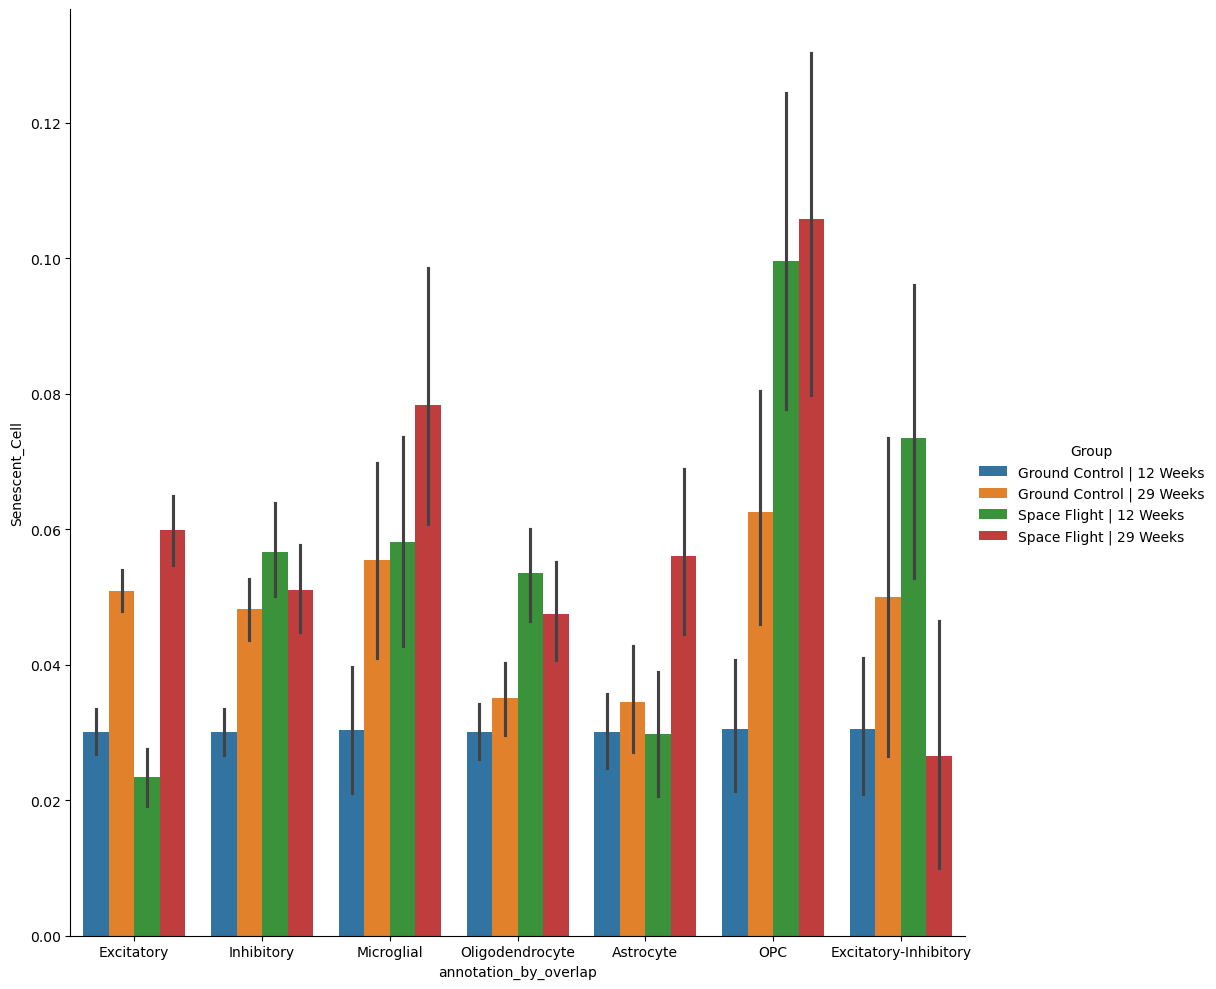

In [9]:
print("Percent Senescent: \n\n", round(self.rna.obs.groupby([
    col_celltype, col_batch]).apply(lambda x: x["Senescent_Cell"].astype(
        int).value_counts(normalize=True)[1], include_groups=False) * 100,
    2).unstack(col_celltype))
sns.catplot(self.rna.obs, y="Senescent_Cell", x=col_celltype,
            hue=col_batch, kind="bar", height=10)

# Plot

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  



                 min  25%  50%  75%   max
Condition                               
Ground Control  0.0  1.7  3.0  4.8  15.0
Space Flight    0.0  3.1  5.4  7.9  17.2


           min  25%  50%  75%   max
Age_End                           
20 Weeks  0.3  2.0  3.5  5.7  12.6
37 Weeks  0.0  2.1  4.4  6.5  17.2


                          min  25%  50%  75%   max
Condition      Age_End                           
Ground Control 20 Weeks  0.3  1.6  2.4  4.3   9.9
               37 Weeks  0.0  1.9  4.0  6.0  15.0
Space Flight   20 Weeks  0.5  3.4  5.0  7.8  12.6
               37 Weeks  0.0  2.9  5.7  8.1  17.2


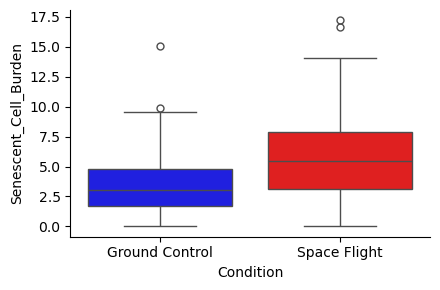

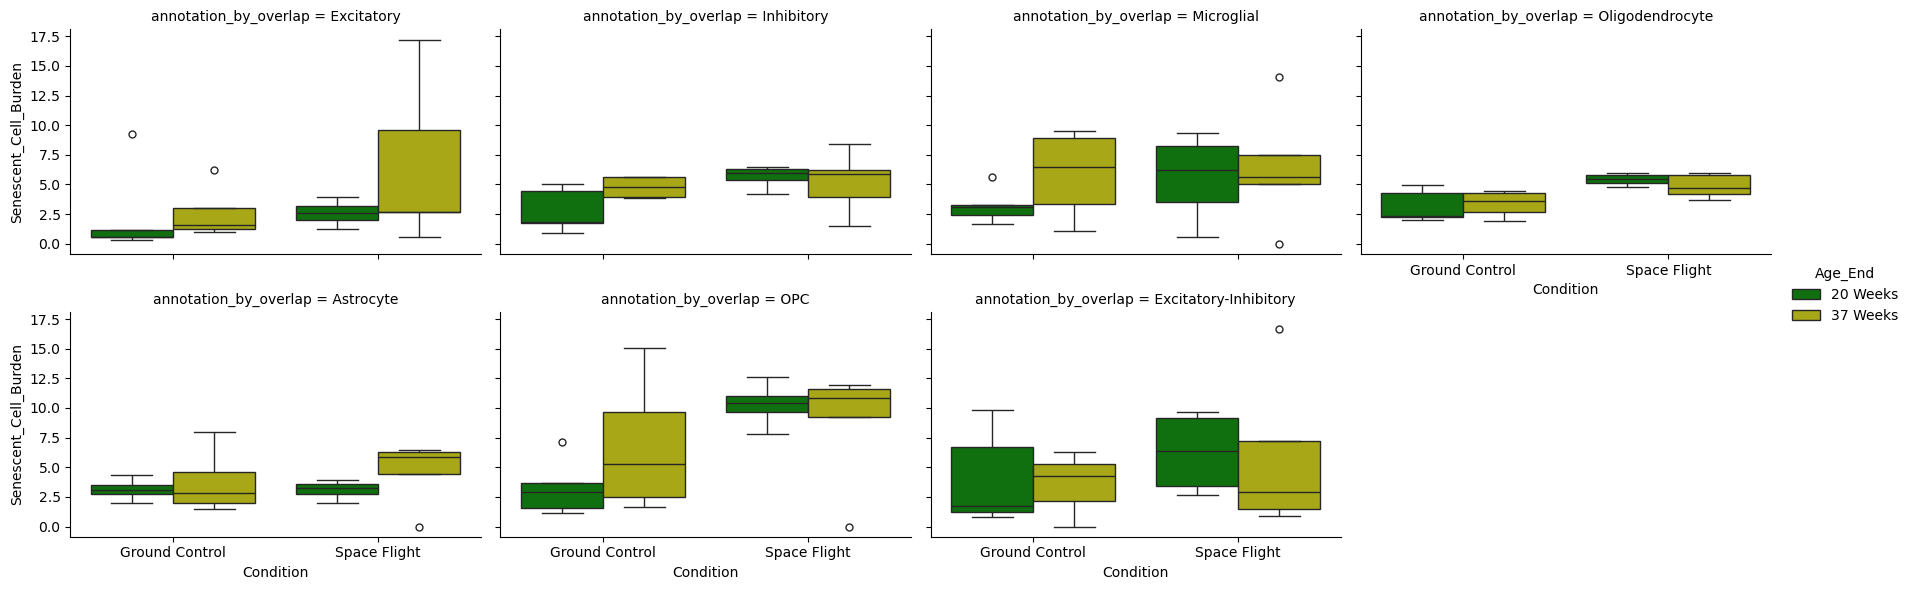

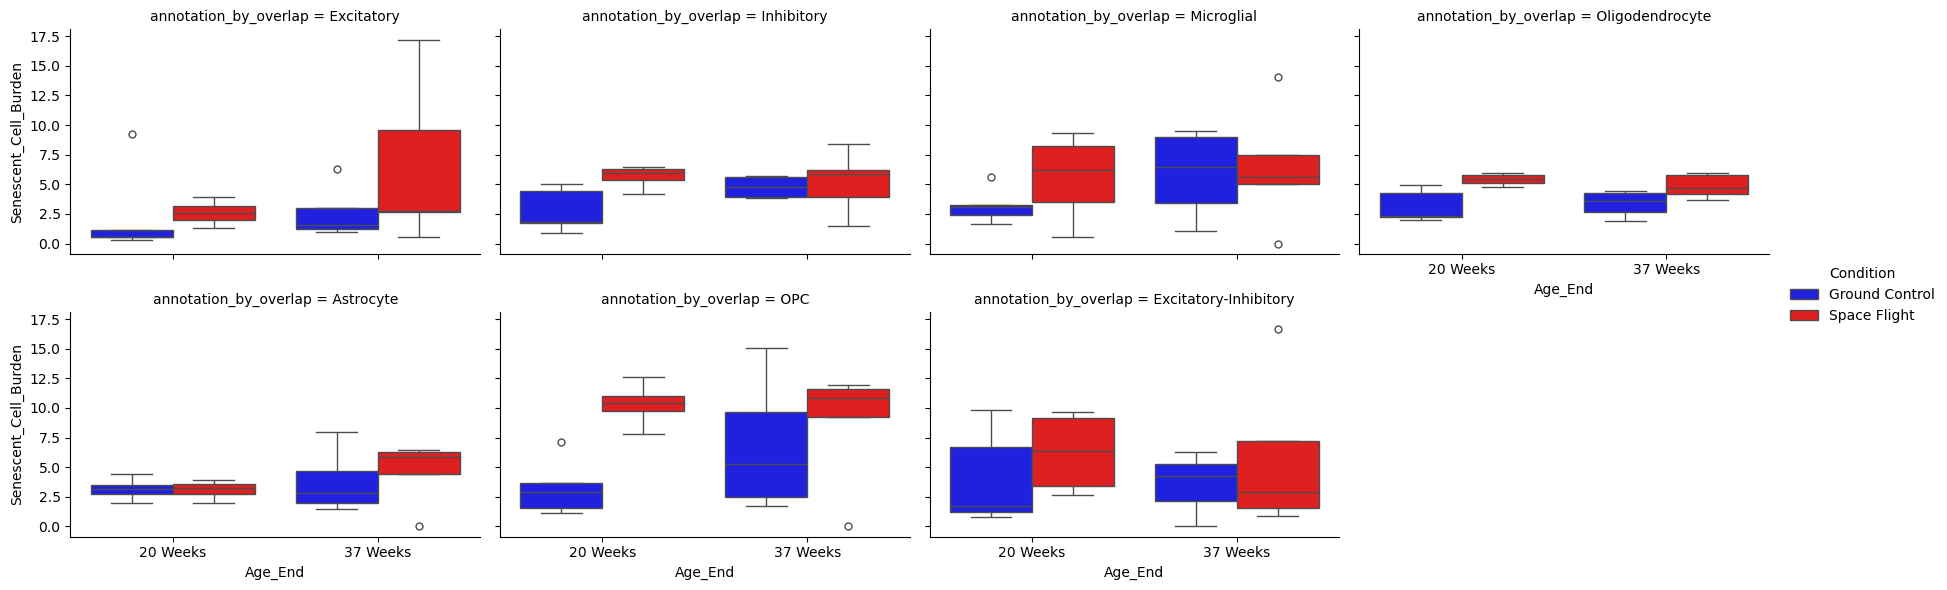

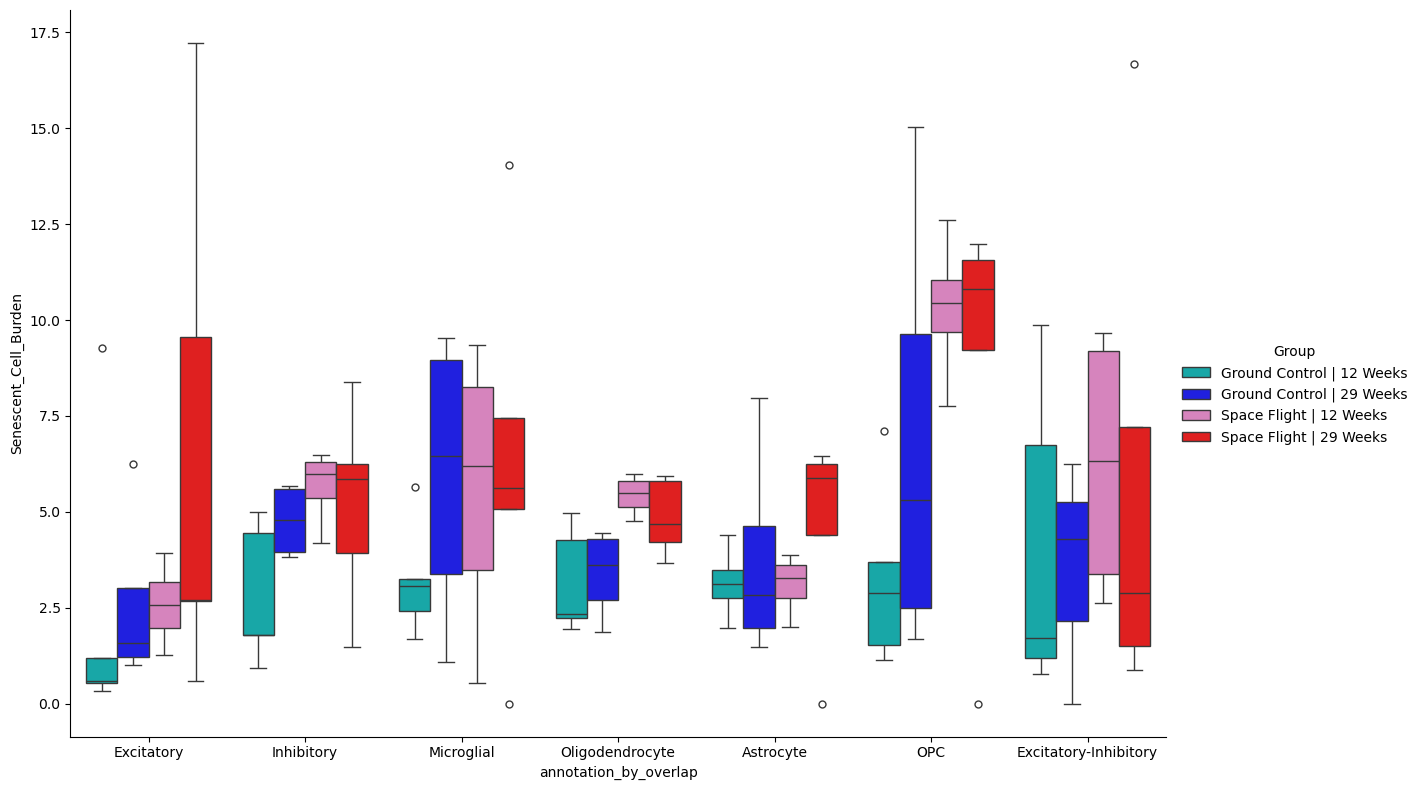

In [10]:
grps = [col_sample, col_celltype, col_age, col_condition, col_batch]
dff = self.rna.obs[grps + ["Senescent_Cell"]].groupby(grps).apply(
    lambda x: x["Senescent_Cell"].mean(), include_groups=False
    ).to_frame("Senescent_Cell_Burden") * 100
# kws_plot = dict(kind="violin", split=False, , common_norm=True)
kws_plot = dict(kind="box", errorbar=("ci", 95))

sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            palette=palette[col_condition],
            hue=col_condition, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            col=col_celltype, col_wrap=4,
            palette=palette[col_age],
            hue=col_age, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", hue=col_condition, **kws_plot,
            col=col_celltype, col_wrap=4,
            palette=palette[col_condition],
            x=col_age, data=dff, height=3, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_celltype, **kws_plot,
            palette=palette[col_batch],
            hue=col_batch, data=dff, height=8, aspect=1.5)
for x in [col_condition, col_age, [col_condition, col_age]]:
    print("\n\n", round(dff["Senescent_Cell_Burden"].groupby(x).describe()[[
        "min", "25%", "50%", "75%", "max"]], 1))

# Analyze

## Regressions & ANOVAs & MEMs

In [11]:
r_dff = polars.DataFrame(dff.reset_index())  # pymer-compatible aggregated df
r_rna = polars.DataFrame(self.rna.obs.copy())  # pymer-compatible cell-level df
lvls = ["key_control", "key_treatment"]
factors = {col_condition: [keys[col_condition][i] for i in lvls],
           col_age: [keys[col_age][i] for i in lvls]}

### Binary Snc/Not

Multilevel Logistic Regression

In [12]:
glmmod = {}
# for x in ["1", f"1 + {col_condition}", f"1 + {col_condition} + {col_age}"]:
#     fff = str(f"Senescent_Cell ~ {col_age} * {col_condition}"
#               f" + (1 | {col_sample}) + ({x} | {col_celltype})")
for x in ["1", f"1 + Spaceflight", f"1 + Spaceflight + Aged"]:
    sep = "|" if x == "1" else "||"
    fff = str(f"Senescent_Cell ~ Aged * Spaceflight"
              f" + (1 | {col_sample}) + ({x} {sep} {col_celltype})")
    glmmod[x] = glmer(fff, data=r_rna, family="binomial")
    # glmmod[x].set_factors(factors)
    glmmod[x].fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
    # print(glmmod[x].emmeans(col_condition))
    # print(glmmod[x].emmeans(col_age))
    glmmod[x].summary().show()
    print(glmmod[x].ranef[col_celltype])
compare(*[glmmod[x] for x in glmmod])

# Plot
# grid = sns.FacetGrid(self.rna.obs, col=col_age, hue=col_condition)
# grid.map(sns.countplot, "Senescent_Cell", order=[False, True])
# grid.add_legend()
# grid.set_xlabels("")
# grid.set_xticklabels(["Not SnC", "Snc"])
# sns.despine()
# fig = plt.figure(figsize=(10, 2))
# g_s = fig.add_gridspec(1, 2, width_ratios=[1, 3])
# left, right = fig.add_subplot(g_s[0]), fig.add_subplot(g_s[1])
# left = sns.kdeplot(x="resid", data=glmmod.data, ax=left)
# left.set(xlabel="Residuals", title="Error Distribution")
# right.stem(glmmod.data["cooksd"], basefmt=" ", label="Cook's Distance")
# right.set(xlabel="Row Number", ylabel="Cook's Distance",
#           title="Influential Observations",
#           xticks=range(glmmod.data.height))
# sns.despine()

Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1|annotation_by_overlap)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18079 
AIC: 36170 | BIC: 36227 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.497 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap-sd 
 (Intercept) 
 0.224 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.027 
 0.018 
 0.041 
 0.006 
 −17.777 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.756 
 1.055 
 2.924 
 0.457 
 2.166 
 inf 
 0.03031 
 * 
 
 
 
 Spaceflight 
 1.887 
 1.126 
 3.163 
 0.497 
 2.410 
 inf 
 0.01596 
 * 
 
 
 
 Aged:Spaceflight 
 0.735 
 0.366 
 1.474 
 0.261 
 −0.867 
 inf 
 0.3858 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

shape: (7, 2)
┌───────────────────────┬─────────────┐
│ level                 ┆ (Intercept) │
│ ---                   ┆ ---         │
│ str                   ┆ f64         │
╞═══════════════════════╪═════════════╡
│ Excitatory            ┆ 0.822477    │
│ Inhibitory            ┆ 0.941349    │
│ Microglial            ┆ 1.147357    │
│ Oligodendrocyte       ┆ 0.886368    │
│ Astrocyte             ┆ 0.799182    │
│ OPC                   ┆ 1.507295    │
│ Excitatory-Inhibitory ┆ 1.064767    │
└───────────────────────┴─────────────┘


Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight||annotation_by_overlap)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18070 
AIC: 36155 | BIC: 36221 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.500 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap-sd 
 (Intercept) 
 0.130 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap.1-sd 
 Spaceflight 
 0.238 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.026 
 0.018 
 0.038 
 0.005 
 −19.059 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.734 
 1.031 
 2.914 
 0.459 
 2.077 
 inf 
 0.03783 
 * 
 
 
 
 Spaceflight 
 2.079 
 1.228 
 3.520 
 0.558 
 2.724 
 inf 
 0.006446 
 ** 
 
 
 
 Aged:Spaceflight 
 0.760 
 0.381 
 1.516 
 0.268 
 −0.779 
 inf 
 0.4362 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

shape: (7, 3)
┌───────────────────────┬─────────────┬─────────────┐
│ level                 ┆ (Intercept) ┆ Spaceflight │
│ ---                   ┆ ---         ┆ ---         │
│ str                   ┆ f64         ┆ f64         │
╞═══════════════════════╪═════════════╪═════════════╡
│ Excitatory            ┆ 0.933986    ┆ 0.766024    │
│ Inhibitory            ┆ 1.015546    ┆ 0.861143    │
│ Microglial            ┆ 1.088194    ┆ 1.09587     │
│ Oligodendrocyte       ┆ 0.903039    ┆ 0.98702     │
│ Astrocyte             ┆ 0.86474     ┆ 0.89327     │
│ OPC                   ┆ 1.192394    ┆ 1.521505    │
│ Excitatory-Inhibitory ┆ 1.045115    ┆ 1.038321    │
└───────────────────────┴─────────────┴─────────────┘


Formula: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight+Aged||annotation_by_overlap)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18058 
AIC: 36133 | BIC: 36209 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.498 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap-sd 
 (Intercept) 
 0.153 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap.1-sd 
 Spaceflight 
 0.227 
 
 
 
 
 
 
 
 
 
 annotation_by_overlap.2-sd 
 Aged 
 0.207 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.026 
 0.018 
 0.038 
 0.005 
 −18.451 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.692 
 1.034 
 2.769 
 0.425 
 2.092 
 inf 
 0.03647 
 * 
 
 
 
 Spaceflight 
 2.051 
 1.242 
 3.388 
 0.525 
 2.805 
 inf 
 0.005038 
 ** 
 
 
 
 Aged:Spaceflight 
 0.770 
 0.434 
 1.367 
 0.225 
 −0.892 
 inf 
 0.3723 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

shape: (7, 4)
┌───────────────────────┬─────────────┬─────────────┬──────────┐
│ level                 ┆ (Intercept) ┆ Spaceflight ┆ Aged     │
│ ---                   ┆ ---         ┆ ---         ┆ ---      │
│ str                   ┆ f64         ┆ f64         ┆ f64      │
╞═══════════════════════╪═════════════╪═════════════╪══════════╡
│ Excitatory            ┆ 0.822066    ┆ 0.759807    ┆ 1.239873 │
│ Inhibitory            ┆ 1.034945    ┆ 0.873911    ┆ 0.972117 │
│ Microglial            ┆ 1.040692    ┆ 1.07077     ┆ 1.178966 │
│ Oligodendrocyte       ┆ 1.016844    ┆ 1.012108    ┆ 0.767774 │
│ Astrocyte             ┆ 0.849287    ┆ 0.906262    ┆ 1.030803 │
│ OPC                   ┆ 1.186732    ┆ 1.46828     ┆ 1.107999 │
│ Excitatory-Inhibitory ┆ 1.109692    ┆ 1.051542    ┆ 0.806892 │
└───────────────────────┴─────────────┴─────────────┴──────────┘


GT(_tbl_data=shape: (3, 10)
┌──────────────┬──────────────┬───────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC          ┆ BIC          ┆ logLik        ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---          ┆ ---          ┆ ---           ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64          ┆ f64          ┆ f64           ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞══════════════╪══════════════╪═══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 36170.588043 ┆ 36227.858889 ┆ -18079.294022 ┆ 6    ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 36155.032246 ┆ 36221.848233 ┆ -18070.516123 ┆ 7    ┆ … ┆ 1.0 ┆ <.001      ┆ ***   ┆ 2   │
│ 36133.228961 ┆ 36209.590089 ┆ -18058.614481 ┆ 8    ┆ … ┆ 1.0 ┆ <.001      ┆ ***   ┆ 3   │
└──────────────┴──────────────┴───────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x771fc094fe50>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x771fc8377820>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1|annotation_by_overlap))   \nModel 2: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight||annotation_by_overlap))   \nModel 3: glmer(Senescent_Cell~Aged*Spaceflight+(1|sample)+(1+Spaceflight+Aged||annotation_by_overlap))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x771fc8377a80>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7723706ec6b0>, <great_tables._gt_data.FormatInfo object at 0x7723706ec9e0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x771fc094f250>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type

### Burden (Percent SnC)

ANOVA: Percent SnCs across (a) Condition x Age and (b) Condition x Age x Cell Type

In [13]:
# Age + Condition
model_1 = lm(
    f"Senescent_Cell_Burden ~ {col_condition} + {col_age}", data=r_dff)
model_1.set_factors(factors)
model_1.anova(summary=True).show()
model_1.summary().show()

# Age + Condition +  Cell Type
model_2 = lm(
    f"Senescent_Cell_Burden ~ {col_condition} + {col_age} + {col_celltype}",
    data=r_dff)
model_2.set_factors(factors)
model_2.anova(summary=True).show()
model_2.summary().show()

# Age + Condition * Cell Type
model_3 = lm(
    f"Senescent_Cell_Burden ~ {col_age} + {col_condition} * {col_celltype}",
    data=r_dff)
model_3.set_factors(factors)
model_3.anova(summary=True).show()

# # Age * Condition * Cell Type
# model_4 = lm(
#     f"Senescent_Cell_Burden ~ {col_age} * {col_condition} * {col_celltype}",
#     data=r_dff)
# model_4.set_factors(factors)
# model_4.anova(summary=True).show()
# model_4.summary().show()

# Compare
# compare(model_1, model_2, model_3, model_4).show()
compare(model_1, model_2, model_3).show()
# compare(model_1, model_2).show()

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Condition 
 1 
 121 
 10.664 
 0.001421 
 ** 
 
 
 Age_End 
 1 
 121 
 2.036 
 0.1562 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End) 
 
 
 Number of observations: 124 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.1032 
R-squared-adj: 0.0884 
 F(2, 121) = 6.965, p = 0.0014 
Log-likelihood: -326 
AIC: 661 | BIC: 672 
Residual error: 3.411 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 3.318 
 0.510 
 2.309 
 4.327 
 6.510 
 121 
 <.001 
 *** 
 
 
 ConditionSpace Flight 
 2.014 
 0.617 
 0.793 
 3.234 
 3.266 
 121 
 0.001421 
 ** 
 
 
 Age_End37 Weeks 
 0.880 
 0.617 
 −0.341 
 2.101 
 1.427 
 121 
 0.1562 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Condition 
 1 
 115 
 11.399 
 0.001003 
 ** 
 
 
 Age_End 
 1 
 115 
 2.213 
 0.1396 
 
 
 
 annotation_by_overlap 
 6 
 115 
 2.409 
 0.03138 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lm(Senescent_Cell_Burden~Condition+Age_End+annotation_by_overlap) 
 
 
 Number of observations: 124 
Confidence intervals: parametric 
--------------------- 
R-squared: 0.2034 
R-squared-adj: 0.1479 
 F(8, 115) = 3.67, p = <.001 
Log-likelihood: -319 
AIC: 658 | BIC: 686 
Residual error: 3.298 
 
 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 df 
 p 
 
 
 
 
 
 (Intercept) 
 2.184 
 0.873 
 0.455 
 3.913 
 2.502 
 115 
 0.01375 
 * 
 
 
 ConditionSpace Flight 
 2.013 
 0.596 
 0.832 
 3.194 
 3.376 
 115 
 0.001003 
 ** 
 
 
 Age_End37 Weeks 
 0.888 
 0.597 
 −0.294 
 2.070 
 1.488 
 115 
 0.1396 
 
 
 
 annotation_by_overlapInhibitory 
 0.894 
 1.099 
 −1.284 
 3.072 
 0.813 
 115 
 0.4177 
 
 
 
 annotation_by_overlapMicroglial 
 1.586 
 1.099 
 −0.591 
 3.764 
 1.443 
 115 
 0.1518 
 
 
 
 annotation_by_overlapOligodendrocyte 
 0.548 
 1.099 
 −1.630 
 2.725 
 0.498 
 115 
 0.6191 
 
 
 
 annotation_by_overlapAstrocyte 
 0.044 
 1.099 
 −2.133 
 2.222 
 0.040 
 115 
 0.9679 
 
 
 
 annotation_by_overlapOPC 
 3.502 
 1.099 
 1.324 
 5.680 
 3.186 
 115 
 0.00186 
 ** 
 
 
 annotation_by_overlapExcitatory-Inhibitory 
 1.367 
 1.134 
 −0.879 
 3.613 
 1.205 
 115 
 0.2305 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 p_value 
 
 
 
 
 
 Age_End 
 1 
 109 
 2.168 
 0.1438 
 
 
 
 Condition 
 1 
 109 
 11.161 
 0.001145 
 ** 
 
 
 annotation_by_overlap 
 6 
 109 
 2.361 
 0.035 
 * 
 
 
 Condition:annotation_by_overlap 
 6 
 109 
 0.615 
 0.7177 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lm(Senescent_Cell_Burden~Condition+Age_End) 
Model 2: lm(Senescent_Cell_Burden~Condition+Age_End+annotation_by_overlap) 
Model 3: lm(Senescent_Cell_Burden~Age_End+Condition*annotation_by_overlap) 
 
 
 
 AIC 
 BIC 
 logLik 
 Res_Df 
 RSS 
 Df 
 Sum of Sq 
 F 
 Pr(>F) 
 
 
 
 
 
 1.00 
 661.2 
 672.5 
 −326.6 
 121.00 
 1.41K 
 
 
 
 
 
 
 
 2.00 
 658.5 
 686.7 
 −319.2 
 115.00 
 1.25K 
 6.00 
 157.21 
 2.36 
 0.035 
 * 
 
 
 3.00 
 666.4 
 711.5 
 −317.2 
 109.00 
 1.21K 
 6.00 
 40.97 
 0.62 
 0.718 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### SnC (Binary) by Cell Type

In [14]:
fff = str(f"Senescent_Cell ~ Aged + Spaceflight * {col_celltype} + "
          "(1 | sample)")
glmmod_ct2 = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2.summary().show()

Formula: glmer(Senescent_Cell~Aged+Spaceflight*annotation_by_overlap+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18053 
AIC: 36138 | BIC: 36291 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.499 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.026 
 0.018 
 0.038 
 0.005 
 −18.746 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.514 
 0.953 
 2.405 
 0.358 
 1.755 
 inf 
 0.07926 
 . 
 
 
 
 Spaceflight 
 1.373 
 0.873 
 2.160 
 0.317 
 1.370 
 inf 
 0.1706 
 
 
 
 
 annotation_by_overlapInhibitory 
 1.093 
 0.982 
 1.215 
 0.059 
 1.634 
 inf 
 0.1023 
 
 
 
 
 annotation_by_overlapMicroglial 
 1.211 
 0.981 
 1.495 
 0.130 
 1.782 
 inf 
 0.07476 
 . 
 
 
 
 annotation_by_overlapOligodendrocyte 
 0.949 
 0.837 
 1.077 
 0.061 
 −0.812 
 inf 
 0.4169 
 
 
 
 
 annotation_by_overlapAstrocyte 
 0.889 
 0.752 
 1.050 
 0.076 
 −1.386 
 inf 
 0.1658 
 
 
 
 
 annotation_by_overlapOPC 
 1.328 
 1.060 
 1.665 
 0.153 
 2.465 
 inf 
 0.01369 
 * 
 
 
 
 annotation_by_overlapExcitatory-Inhibitory 
 1.166 
 0.874 
 1.556 
 0.172 
 1.046 
 inf 
 0.2955 
 
 
 
 
 Spaceflight:annotation_by_overlapInhibitory 
 1.123 
 0.954 
 1.322 
 0.094 
 1.393 
 inf 
 0.1637 
 
 
 
 
 Spaceflight:annotation_by_overlapMicroglial 
 1.414 
 1.051 
 1.902 
 0.214 
 2.289 
 inf 
 0.02208 
 * 
 
 
 
 Spaceflight:annotation_by_overlapOligodendrocyte 
 1.325 
 1.103 
 1.592 
 0.124 
 3.010 
 inf 
 0.002613 
 ** 
 
 
 
 Spaceflight:annotation_by_overlapAstrocyte 
 1.206 
 0.930 
 1.565 
 0.160 
 1.411 
 inf 
 0.1582 
 
 
 
 
 Spaceflight:annotation_by_overlapOPC 
 2.062 
 1.526 
 2.785 
 0.316 
 4.713 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_by_overlapExcitatory-Inhibitory 
 1.336 
 0.879 
 2.030 
 0.285 
 1.355 
 inf 
 0.1754 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Just Age as Predictor

In [15]:
model_cac_mlm_i3_a = lmer(
    f"senscore ~  {col_age} * {col_celltype} + (1 | {col_sample})",
    data=r_rna)  # setup model
model_cac_mlm_i3_a.set_factors(factors)
model_cac_mlm_i3_a.set_transforms({"senscore": "zscore"})
model_cac_mlm_i3_a.fit()
model_cac_mlm_i3_a.summary().show()

fff = str(f"Senescent_Cell ~ Aged * {col_celltype} + "
          "(1 | sample)")
glmmod_ct2a = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2a.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2a.summary().show()

Formula: lmer(senscore~Age_End*annotation_by_overlap+(1|sample)) 
 
 
 Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -138881 
AIC: 277795 | BIC: 277947 
Residual error: 0.928 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.166 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.928 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 −0.014 
 0.056 
 −0.132 
 0.104 
 −0.244 
 16.336 
 0.81 
 
 
 
 
 Age_End37 Weeks 
 0.199 
 0.079 
 0.032 
 0.365 
 2.519 
 16.267 
 0.0226 
 * 
 
 
 
 annotation_by_overlapInhibitory 
 −0.223 
 0.011 
 −0.245 
 −0.201 
 −19.724 
 103,257.788 
 <.001 
 *** 
 
 
 
 annotation_by_overlapMicroglial 
 0.861 
 0.022 
 0.818 
 0.903 
 39.821 
 103,249.264 
 
 *** 
 
 
 
 annotation_by_overlapOligodendrocyte 
 −0.409 
 0.012 
 −0.432 
 −0.385 
 −33.734 
 103,258.553 
 <.001 
 *** 
 
 
 
 annotation_by_overlapAstrocyte 
 0.498 
 0.016 
 0.467 
 0.529 
 31.269 
 103,253.186 
 <.001 
 *** 
 
 
 
 annotation_by_overlapOPC 
 0.274 
 0.024 
 0.228 
 0.321 
 11.560 
 103,248.370 
 <.001 
 *** 
 
 
 
 annotation_by_overlapExcitatory-Inhibitory 
 −0.631 
 0.025 
 −0.680 
 −0.583 
 −25.543 
 103,253.754 
 <.001 
 *** 
 
 
 
 Age_End37 Weeks:annotation_by_overlapInhibitory 
 −0.040 
 0.016 
 −0.070 
 −0.009 
 −2.525 
 103,223.181 
 0.01158 
 * 
 
 
 
 Age_End37 Weeks:annotation_by_overlapMicroglial 
 −0.033 
 0.032 
 −0.095 
 0.030 
 −1.027 
 103,255.054 
 0.3042 
 
 
 
 
 Age_End37 Weeks:annotation_by_overlapOligodendrocyte 
 −0.126 
 0.017 
 −0.160 
 −0.092 
 −7.286 
 103,249.497 
 <.001 
 *** 
 
 
 
 Age_End37 Weeks:annotation_by_overlapAstrocyte 
 −0.000 
 0.023 
 −0.045 
 0.045 
 −0.003 
 103,259.812 
 0.9978 
 
 
 
 
 Age_End37 Weeks:annotation_by_overlapOPC 
 −0.077 
 0.035 
 −0.145 
 −0.008 
 −2.194 
 103,253.684 
 0.02826 
 * 
 
 
 
 Age_End37 Weeks:annotation_by_overlapExcitatory-Inhibitory 
 −0.172 
 0.045 
 −0.260 
 −0.085 
 −3.847 
 103,257.305 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Aged*annotation_by_overlap+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18048 
AIC: 36126 | BIC: 36269 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.548 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.025 
 0.018 
 0.036 
 0.004 
 −20.942 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 2.001 
 1.247 
 3.209 
 0.482 
 2.877 
 inf 
 0.004012 
 ** 
 
 
 
 annotation_by_overlapInhibitory 
 1.382 
 1.213 
 1.576 
 0.092 
 4.843 
 inf 
 <.001 
 *** 
 
 
 
 annotation_by_overlapMicroglial 
 1.494 
 1.198 
 1.863 
 0.168 
 3.561 
 inf 
 <.001 
 *** 
 
 
 
 annotation_by_overlapOligodendrocyte 
 1.481 
 1.289 
 1.702 
 0.105 
 5.544 
 inf 
 <.001 
 *** 
 
 
 
 annotation_by_overlapAstrocyte 
 1.082 
 0.888 
 1.319 
 0.109 
 0.786 
 inf 
 0.4321 
 
 
 
 
 annotation_by_overlapOPC 
 2.202 
 1.773 
 2.736 
 0.244 
 7.131 
 inf 
 <.001 
 *** 
 
 
 
 annotation_by_overlapExcitatory-Inhibitory 
 1.886 
 1.459 
 2.436 
 0.247 
 4.851 
 inf 
 <.001 
 *** 
 
 
 
 Aged:annotation_by_overlapInhibitory 
 0.757 
 0.641 
 0.893 
 0.064 
 −3.288 
 inf 
 0.001007 
 ** 
 
 
 
 Aged:annotation_by_overlapMicroglial 
 0.979 
 0.733 
 1.309 
 0.145 
 −0.141 
 inf 
 0.8876 
 
 
 
 
 Aged:annotation_by_overlapOligodendrocyte 
 0.577 
 0.479 
 0.695 
 0.055 
 −5.795 
 inf 
 <.001 
 *** 
 
 
 
 Aged:annotation_by_overlapAstrocyte 
 0.856 
 0.660 
 1.110 
 0.114 
 −1.176 
 inf 
 0.2397 
 
 
 
 
 Aged:annotation_by_overlapOPC 
 0.831 
 0.624 
 1.107 
 0.121 
 −1.267 
 inf 
 0.2053 
 
 
 
 
 Aged:annotation_by_overlapExcitatory-Inhibitory 
 0.434 
 0.272 
 0.694 
 0.104 
 −3.487 
 inf 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Three-Way Interaction

In [ ]:
# Binary
fff = str(f"Senescent_Cell ~ Aged * {col_celltype} * Spaceflight"
          f" + (1 | {col_sample})")
model_allix = glmer(fff, data=r_rna, family="binomial")
model_allix.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
model_allix.anova(summary=True).show()
model_allix.summary().show()
res_allix_fixed = pd.DataFrame(model_allix.result_fit[[
    "term", "estimate", "p_value"]], columns=[
        "Term", "OR", "P"]).set_index("Term")
res_allix_fixed.loc[:, "Log-Odds"] = np.log(res_allix_fixed.OR.astype(float))
res_allix_fixed.loc[:, "Significance"] = res_allix_fixed.P.apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if (
        x < 0.05) else "")
res_allix_fixed

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Aged 
 1.000 
 inf 
 2.119 
 2.119 
 0.1455 
 
 
 
 Spaceflight 
 1.000 
 inf 
 5.201 
 5.201 
 0.02257 
 * 
 
 
 annotation_by_overlap 
 6.000 
 inf 
 17.487 
 104.922 
 <.001 
 *** 
 
 
 Aged:Spaceflight 
 1.000 
 inf 
 0.313 
 0.313 
 0.5761 
 
 
 
 Aged:annotation_by_overlap 
 6.000 
 inf 
 9.051 
 54.306 
 <.001 
 *** 
 
 
 Spaceflight:annotation_by_overlap 
 6.000 
 inf 
 6.596 
 39.576 
 <.001 
 *** 
 
 
 Aged:Spaceflight:annotation_by_overlap 
 6.000 
 inf 
 8.906 
 53.436 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Aged*Spaceflight*annotation_by_overlap+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 103274 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -18003 
AIC: 36064 | BIC: 36341 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.490 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.024 
 0.015 
 0.039 
 0.006 
 −15.028 
 inf 
 <.001 
 *** 
 
 
 
 Aged 
 1.756 
 0.808 
 3.813 
 0.695 
 1.422 
 inf 
 0.1549 
 
 
 
 
 Spaceflight 
 1.015 
 0.466 
 2.210 
 0.403 
 0.038 
 inf 
 0.9699 
 
 
 
 
 annotation_by_overlapInhibitory 
 0.987 
 0.832 
 1.171 
 0.086 
 −0.153 
 inf 
 0.8786 
 
 
 
 
 annotation_by_overlapMicroglial 
 1.056 
 0.754 
 1.480 
 0.182 
 0.319 
 inf 
 0.7497 
 
 
 
 
 annotation_by_overlapOligodendrocyte 
 1.158 
 0.961 
 1.395 
 0.110 
 1.539 
 inf 
 0.1238 
 
 
 
 
 annotation_by_overlapAstrocyte 
 0.991 
 0.781 
 1.258 
 0.121 
 −0.075 
 inf 
 0.9405 
 
 
 
 
 annotation_by_overlapOPC 
 1.161 
 0.799 
 1.686 
 0.221 
 0.785 
 inf 
 0.4327 
 
 
 
 
 annotation_by_overlapExcitatory-Inhibitory 
 1.367 
 0.949 
 1.969 
 0.254 
 1.681 
 inf 
 0.09281 
 . 
 
 
 
 Aged:Spaceflight 
 1.375 
 0.438 
 4.318 
 0.803 
 0.546 
 inf 
 0.5854 
 
 
 
 
 Aged:annotation_by_overlapInhibitory 
 1.217 
 0.973 
 1.522 
 0.139 
 1.724 
 inf 
 0.08468 
 . 
 
 
 
 Aged:annotation_by_overlapMicroglial 
 1.299 
 0.830 
 2.035 
 0.298 
 1.144 
 inf 
 0.2526 
 
 
 
 
 Aged:annotation_by_overlapOligodendrocyte 
 0.673 
 0.517 
 0.876 
 0.090 
 −2.947 
 inf 
 0.003211 
 ** 
 
 
 
 Aged:annotation_by_overlapAstrocyte 
 0.799 
 0.566 
 1.130 
 0.141 
 −1.269 
 inf 
 0.2044 
 
 
 
 
 Aged:annotation_by_overlapOPC 
 1.283 
 0.785 
 2.097 
 0.322 
 0.992 
 inf 
 0.3211 
 
 
 
 
 Aged:annotation_by_overlapExcitatory-Inhibitory 
 0.672 
 0.371 
 1.216 
 0.203 
 −1.315 
 inf 
 0.1887 
 
 
 
 
 Spaceflight:annotation_by_overlapInhibitory 
 2.483 
 1.848 
 3.337 
 0.374 
 6.032 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_by_overlapMicroglial 
 2.383 
 1.447 
 3.923 
 0.606 
 3.414 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_by_overlapOligodendrocyte 
 1.972 
 1.447 
 2.687 
 0.312 
 4.297 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_by_overlapAstrocyte 
 1.267 
 0.813 
 1.975 
 0.287 
 1.046 
 inf 
 0.2957 
 
 
 
 
 Spaceflight:annotation_by_overlapOPC 
 3.907 
 2.353 
 6.487 
 1.011 
 5.267 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:annotation_by_overlapExcitatory-Inhibitory 
 2.281 
 1.310 
 3.972 
 0.646 
 2.914 
 inf 
 0.003564 
 ** 
 
 
 
 Aged:Spaceflight:annotation_by_overlapInhibitory 
 0.294 
 0.204 
 0.425 
 0.055 
 −6.525 
 inf 
 <.001 
 *** 
 
 
 
 Aged:Spaceflight:annotation_by_overlapMicroglial 
 0.482 
 0.251 
 0.926 
 0.161 
 −2.189 
 inf 
 0.02859 
 * 
 
 
 
 Aged:Spaceflight:annotation_by_overlapOligodendrocyte 
 0.612 
 0.408 
 0.919 
 0.127 
 −2.370 
 inf 
 0.01778 
 * 
 
 
 
 Aged:Spaceflight:annotation_by_overlapAstrocyte 
 1.100 
 0.628 
 1.928 
 0.315 
 0.334 
 inf 
 0.7385 
 
 
 
 
 Aged:Spaceflight:annotation_by_overlapOPC 
 0.386 
 0.198 
 0.752 
 0.131 
 −2.795 
 inf 
 0.005192 
 ** 
 
 
 
 Aged:Spaceflight:annotation_by_overlapExcitatory-Inhibitory 
 0.319 
 0.112 
 0.915 
 0.171 
 −2.126 
 inf 
 0.03352 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

,OR,P,Log-Odds,Significance
Term,,,,
(Intercept),0.023961,0.0,-3.731328,***
Aged,1.755729,0.154893,0.562884,
Spaceflight,1.015114,0.969854,0.015001,
annotation_by_overlapInhibitory,0.986773,0.878563,-0.013315,
annotation_by_overlapMicroglial,1.056431,0.749692,0.054896,
annotation_by_overlapOligodendrocyte,1.157791,0.123793,0.146514,
annotation_by_overlapAstrocyte,0.990961,0.940483,-0.009080,
annotation_by_overlapOPC,1.161143,0.43272,0.149405,
annotation_by_overlapExcitatory-Inhibitory,1.367278,0.092808,0.312822,


## Composition Analysis

### Senescent Cells



By Cell Type




/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

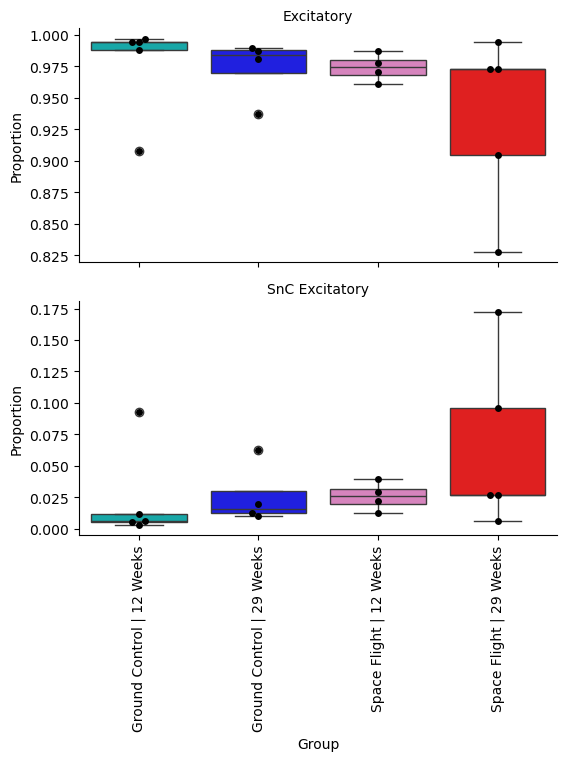

INFO:2025-08-20 16:45:37,719:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-08-20 16:45:37 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
sample: 100%|█| 11000/11000 [29:55<00:00,  6.13it/s, 1023 steps of size 2.19e-1
2025-08-20 17:15:37 | [INFO] arviz_base not installed
2025-08-20 17:15:37 | [INFO] arviz_stats not installed
2025-08-20 17:15:37 | [INFO] arviz_plots not installed


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ Excitatory                                                        │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Excitatory                        40.610          2291.833                                                      │
│ SnC Excitatory                     0.369             0.000                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  Final Parameter  Expected Sample  log2-fold change             │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Excitatory           0.000          2291.833            0.000                  │
│                                  SnC Excitatory       0.000             0.000            0.000                  │
│ GroupT.Space Flight | 12 Weeks   Excitatory           0.000             0.000          -32.644                  │
│                                  SnC Excitatory      62.868          2291.833           58.055                  │
│ GroupT.Space Flight | 29 Weeks   Excitatory           0.000          2291.833            0.000                  │
│                                  SnC Excitatory      -0.076             0.000           -0.110                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

• Zero counts encountered in data! Added a pseudocount of 0.5.


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

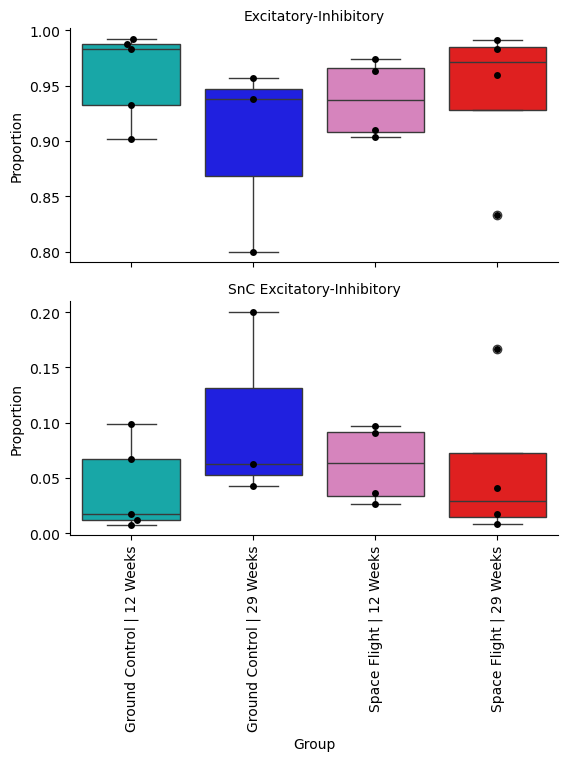

sample: 100%|█| 11000/11000 [33:05<00:00,  5.54it/s, 1023 steps of size 2.15e-1


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 16 samples, 2 cell types                                    │
│ Reference cell type                         │ Excitatory-Inhibitory                                             │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Excitatory-Inhibitory             38.160          138.844                                                       │
│ SnC Excitatory-Inhibitory          2.401            0.000                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                             Final Parameter  Expected Sample  log2-fold change  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Excitatory-Inhibitory           0.000          138.844             0.000       │
│                                  SnC Excitatory-Inhibitory       0.000            0.000             0.000       │
│ GroupT.Space Flight | 12 Weeks   Excitatory-Inhibitory           0.000            0.000           -58.405       │
│                                  SnC Excitatory-Inhibitory      76.242          138.844            51.589       │
│ GroupT.Space Flight | 29 Weeks   Excitatory-Inhibitory           0.000          138.844             0.000       │
│                                  SnC Excitatory-Inhibitory       0.000            0.000             0.000       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

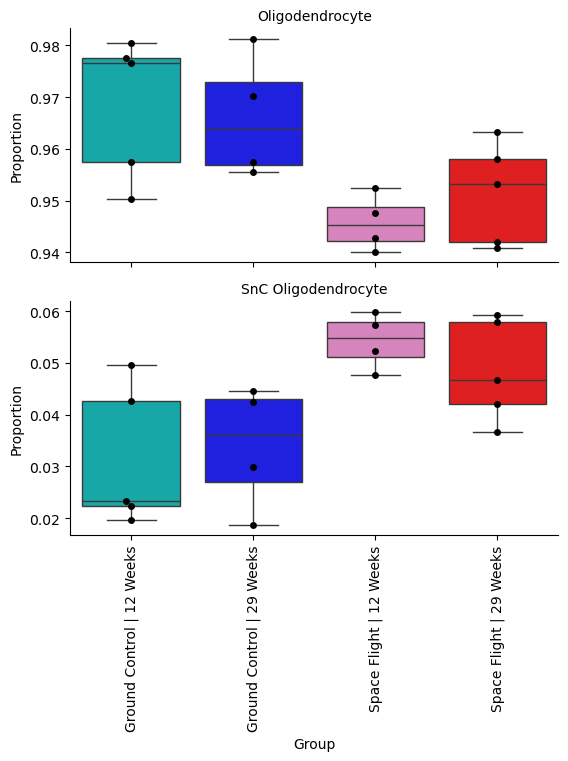

sample: 100%|█| 11000/11000 [26:02<00:00,  7.04it/s, 1023 steps of size 2.94e-1


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ Oligodendrocyte                                                   │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Oligodendrocyte                   37.656          1026.944                                                      │
│ SnC Oligodendrocyte                4.117             0.000                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                       Final Parameter  Expected Sample  log2-fold change        │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Oligodendrocyte           0.000          1026.944            0.000             │
│                                  SnC Oligodendrocyte       0.000             0.000            0.000             │
│ GroupT.Space Flight | 12 Weeks   Oligodendrocyte           0.000          1026.944           -0.000             │
│                                  SnC Oligodendrocyte       1.363             0.000            1.967             │
│ GroupT.Space Flight | 29 Weeks   Oligodendrocyte           0.000             0.000          -70.648             │
│                                  SnC Oligodendrocyte      82.508          1026.944           48.387             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

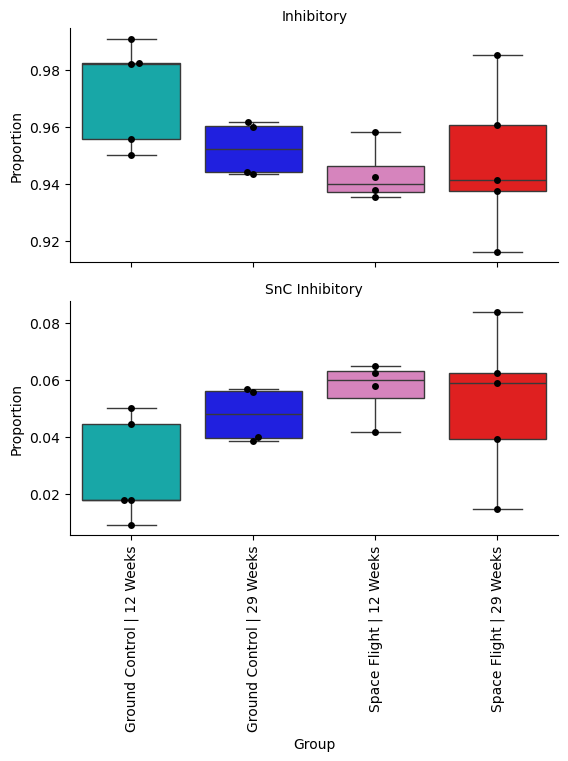

sample: 100%|█| 11000/11000 [22:31<00:00,  8.14it/s, 1 steps of size 2.58e-16. 


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ Inhibitory                                                        │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Inhibitory                        36.828          1454.611                                                      │
│ SnC Inhibitory                     4.199             0.000                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  Final Parameter  Expected Sample  log2-fold change             │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Inhibitory           0.000          1454.611             0.000                 │
│                                  SnC Inhibitory       0.000             0.000             0.000                 │
│ GroupT.Space Flight | 12 Weeks   Inhibitory           0.000             0.000          -193.599                 │
│                                  SnC Inhibitory     166.822          1454.611            47.074                 │
│ GroupT.Space Flight | 29 Weeks   Inhibitory           0.000          1454.611             0.000                 │
│                                  SnC Inhibitory       0.000             0.000             0.000                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

• Zero counts encountered in data! Added a pseudocount of 0.5.


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

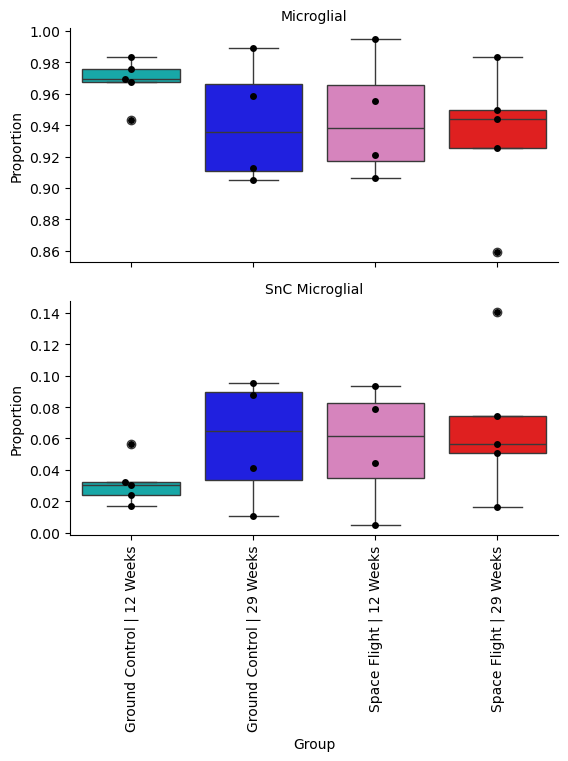

sample: 100%|█| 11000/11000 [33:36<00:00,  5.45it/s, 1023 steps of size 2.44e-1


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ Microglial                                                        │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Microglial                        40.652          213.583                                                       │
│ SnC Microglial                     2.306            0.000                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                  Final Parameter  Expected Sample  log2-fold change             │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Microglial           0.000          213.583             0.000                  │
│                                  SnC Microglial       0.829            0.000             1.196                  │
│ GroupT.Space Flight | 12 Weeks   Microglial           0.000          213.583             0.000                  │
│                                  SnC Microglial       0.000            0.000             0.000                  │
│ GroupT.Space Flight | 29 Weeks   Microglial           0.000            0.000           -22.831                  │
│                                  SnC Microglial      54.171          213.583            55.322                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

• Zero counts encountered in data! Added a pseudocount of 0.5.


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

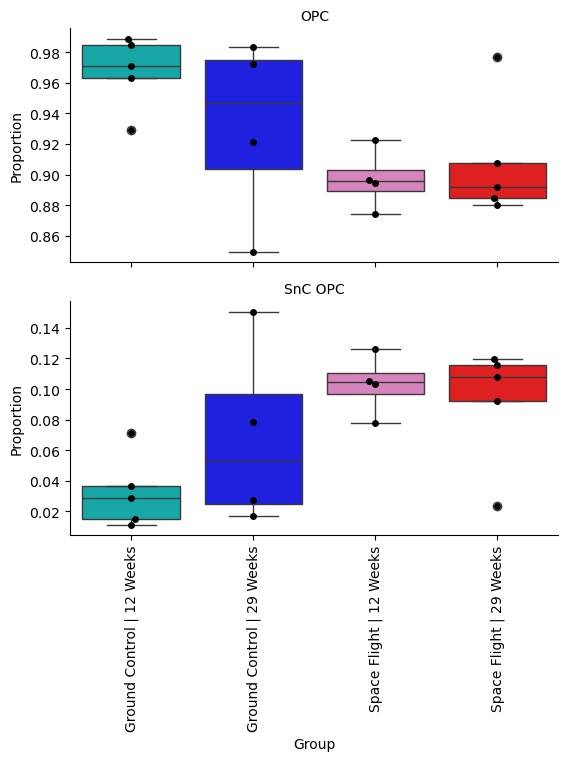

sample: 100%|█| 11000/11000 [24:46<00:00,  7.40it/s, 1023 steps of size 2.44e-1


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ OPC                                                               │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ OPC                               37.342          173.417                                                       │
│ SnC OPC                            3.472            0.000                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks OPC             0.000          173.417              0.000                      │
│                                  SnC OPC         0.000            0.000              0.000                      │
│ GroupT.Space Flight | 12 Weeks   OPC             0.000          173.417             -0.000                      │
│                                  SnC OPC         0.670            0.000              0.967                      │
│ GroupT.Space Flight | 29 Weeks   OPC             0.000            0.000           -118.325                      │
│                                  SnC OPC       115.886          173.417             48.864                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

• Zero counts encountered in data! Added a pseudocount of 0.5.


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  

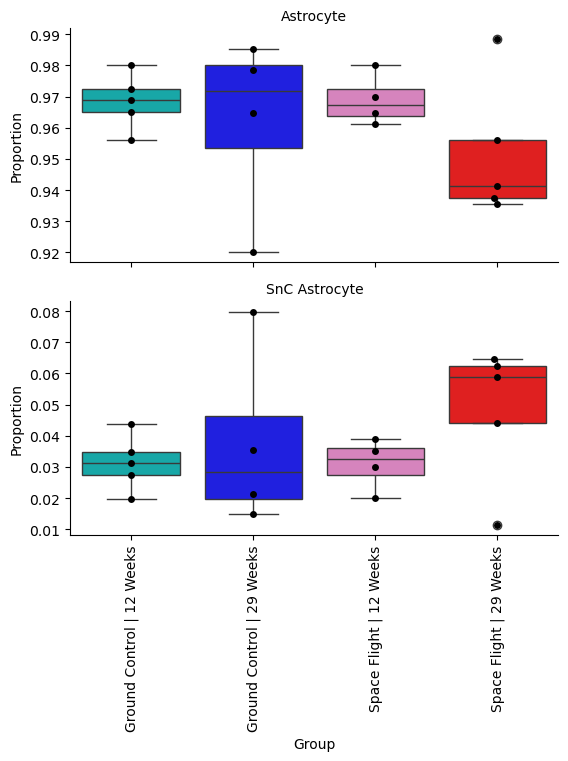

sample: 100%|█| 11000/11000 [31:40<00:00,  5.79it/s, 1023 steps of size 2.22e-1


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 18 samples, 2 cell types                                    │
│ Reference cell type                         │ Astrocyte                                                         │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample                                                  │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                         40.644          453.750                                                       │
│ SnC Astrocyte                     12.316            0.000                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                 Final Parameter  Expected Sample  log2-fold change              │
│ Covariate                        Cell Type                                                                      │
│ GroupT.Ground Control | 29 Weeks Astrocyte           0.000          453.750            -0.000                   │
│                                  SnC Astrocyte       2.527            0.000             3.645                   │
│ GroupT.Space Flight | 12 Weeks   Astrocyte           0.000          453.750            -0.000                   │
│                                  SnC Astrocyte       0.172            0.000             0.248                   │
│ GroupT.Space Flight | 29 Weeks   Astrocyte           0.000            0.000           -53.178                   │
│                                  SnC Astrocyte      65.188          453.750            40.869                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

CPU times: user 3h 22min 10s, sys: 40.6 s, total: 3h 22min 51s
Wall time: 3h 22min 23s


In [ ]:
%%time

# print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
# out_ctc = scflow.ax.analyze_composition(
#     self.rna, "Senescent_Cell_Label", col_batch, col_sample=col_sample,
#     formula=None, key_modality="coda", reference_cell_type="Non-Senescent",
#     palette=palette[col_batch],
#     absence_threshold=0.1, est_fdr=0.1, seed=1618, level_order=[keys[
#         col_batch]["key_control"]] + keys[col_batch]["key_treatment"])
# plt.show()

# print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
# out_ctc_old = scflow.ax.analyze_composition(
#     self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]],
#     "Senescent_Cell_Label", col_condition, col_sample=col_sample,
#     palette=palette[col_batch],
#     formula=None, key_modality="coda", reference_cell_type="Non-Senescent",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[
#         col_condition]["key_control"]] + [
#             keys[col_condition]["key_treatment"]])

print(f"\n\n{'=' * 80}\nBy Cell Type\n{'=' * 80}\n\n")
out_ctc_ct = {}
for x in self.rna.obs[col_celltype].unique():
    out_ctc_ct[x] = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        "Senescent_Cell_Label_by_Type", col_batch, col_sample=col_sample,
        formula=None, key_modality="coda",
        palette=palette[col_batch], seed=1618,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.1,
        level_order=[keys[col_batch]["key_control"]] + keys[
            col_batch]["key_treatment"])
    if overwrite is True or os.path.exists(
            f"outputs/sccoda_results_{x}_3pct.pkl") is False:
        with open(f"outputs/sccoda_results_{x}_3pct.pkl", "wb") as f:
            pickle.dump(out_ctc_ct[x][0], f)
        out_ctc_ct[x][1].write_h5mu(f"outputs/sccoda_data_{x}_3pct.pkl")
    plt.show()

# print(f"\n\n{'=' * 80}\nBy Cell Type (Aged Subset)\n{'=' * 80}\n\n")
# ref_cell = self.rna.obs[col_celltype].value_counts().index.values[0]
# out_ctc = scflow.ax.analyze_composition(
#     self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]],
#     "Senescent_Cell_Label_by_Type", col_condition,
#     palette=palette[col_batch],
#     col_sample=col_sample, formula=None, absence_threshold=0.1, est_fdr=0.1,
#     level_order=[keys[col_condition]["key_control"]] + [
#         keys[col_condition]["key_treatment"]])

## Differential Gene Expression

Mainly using `edgeR`

### SnC DEGs

#### SnCs vs. Not

*Slc23a2*

##### Overall

In [ ]:
out_edgr_contrasts_snc = scflow.ax.run_deg_edgr(
    self.rna, "Senescent_Cell_Label",
    col_covariate=col_batch, formula=None,
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)

##### Rank Genes Groups

In [ ]:
res_rank_genes, p_threshold = {}, 1e-10
for x in self.rna.obs[col_batch].unique():
    res_rank_genes[x] = {}
    for c in self.rna.obs[self.rna.obs[col_batch] == x][col_celltype].unique():
        s_iter = (self.rna.obs[col_batch] == x) & (self.rna.obs[
            "Senescent_Cell_Label_by_Type"].isin([c, f"SnC {c}"]))
        tmp = sc.tl.rank_genes_groups(
            self.rna[s_iter], "Senescent_Cell_Label_by_Type", rankby_abs=True,
            layer="log1p", groups=[c, f"SnC {c}"], reference=c, copy=True)
        res_rank_genes[x][c] = sc.get.rank_genes_groups_df(
            tmp, f"SnC {c}", pval_cutoff=p_threshold)
    tmp = sc.tl.rank_genes_groups(
            self.rna[self.rna.obs[col_batch] == x],
            "Senescent_Cell_Label", rankby_abs=True,
            layer="log1p", reference="Non-Senescent", copy=True)
    res_rank_genes[x]["Overall"] = sc.get.rank_genes_groups_df(
            tmp, f"Senescent", pval_cutoff=p_threshold)
    res_rank_genes[x] = pd.concat(res_rank_genes[x], names=[col_celltype])
res_rank_genes = pd.concat(res_rank_genes, names=[col_batch])
res_rank_genes = res_rank_genes.assign(
    logfoldchanges_abs=res_rank_genes.logfoldchanges.abs())
res_rank_genes_top = res_rank_genes.reset_index().groupby([
    col_batch, col_celltype]).apply(
        lambda x: x.sort_values("logfoldchanges_abs").iloc[:20],
        include_groups=False).reset_index(2, drop=True).set_index(
            "names", append=True).rename_axis([
                col_batch, col_celltype, "variable"])
res_rank_genes_top

##### By Condition (Just Aged)

In [ ]:
# Ager Subset
subset_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]

# Old Ground Control SnCs
print(f"\n\n{'=' * 80}\nGround Control (Aged)\n{'=' * 80}\n\n")
subset_gc = self.rna.obs[col_condition] == keys[
    col_condition]["key_control"]
out_edgr_contrasts_snc_gc = scflow.ax.run_deg_edgr(
    self.rna[subset_gc & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", top=0.92,
    key_control="Non-Senescent", log2fc_thresh=0, n_top_vars=24,
    xlabel_rotation=45, hspace=0.5, wspace=0.2, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_gc & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_1 = self.rna[subset_gc & subset_old].obs[col_batch].unique()[0]

# Old Spaceflight SnCs
print(f"\n\n{'=' * 80}\nSpaceflight (Aged)\n{'=' * 80}\n\n")
subset_sf = self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]
out_edgr_contrasts_snc_sf = scflow.ax.run_deg_edgr(
    self.rna[subset_sf & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_sf & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_2 = self.rna[subset_sf & subset_old].obs[col_batch].unique()[0]

# Compare
res_snc_gc = out_edgr_contrasts_snc_gc[0][out_edgr_contrasts_snc_gc[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_sf = out_edgr_contrasts_snc_sf[0][out_edgr_contrasts_snc_sf[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_grps = pd.concat([
    res_snc_gc, res_snc_sf], keys=[key_1, key_2], names=[col_condition])
res_snc_grps = res_snc_grps[res_snc_grps.abs_log_fc >= 1]
# top_tx_g_snc = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].sort_values("abs_log_fc", ascending=False).index
# print(res_snc_grps.unstack(0).replace(np.nan, "")[[
#     "log_fc", "adj_p_value"]].loc[top_tx_g_snc])
# just_sf = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_control"]].index)
# just_gc = res_snc_grps.loc[keys[col_condition][
#     "key_control"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_treatment"]].index)
# print(res_snc_grps.loc[:, just_gc, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]], "\n\n")
# res_snc_grps.loc[:, just_sf, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]]
res_snc_grps.unstack(0).replace(np.nan, "")[["log_fc", "adj_p_value"]]

#### SnC as Covariate

In [ ]:
out_edgr_contrasts_snc_cov = {}
for a in self.rna.obs[col_age].unique():
    print(f"\n\n{'=' * 80}\nAge = {a}\n{'=' * 80}\n\n")
    out_edgr_contrasts_snc_cov[a] = scflow.ax.run_deg_edgr(
        self.rna[self.rna.obs[col_age] == a], col_condition,
        col_covariate="Senescent_Cell_Label",
        **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
        xlabel_rotation=45, hspace=0.5, wspace=0.2, top=0.85,
        legend_loc="upper right", col_celltype=col_celltype,
        col_sample=col_sample)
    plt.show()

#### Just SnCs

##### All Groups SnCs

In [ ]:
out_edgr_groups_snc = scflow.ax.run_deg_edgr(
    self.rna[(self.rna.obs["Senescent_Cell_Label"] == "Senescent")],
    col_batch, **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
out_edgr_batches_snc = out_edgr_groups[0][(
    out_edgr_groups[0].abs_log_fc > 1) & (
        out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
plt.show()

##### SF vs. Aged GC

In [ ]:
# subs_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]
# subs_sf = self.rna.obs[col_condition] == keys[
#     col_condition]["key_treatment"]
# subs_noynggc_snc = (self.rna.obs[
#     "Senescent_Cell_Label"] == "Senescent") & (
#     subs_old | subs_sf)
# # ktx = keys[col_batch]["key_treatment"][1:]
# ktx = [keys[col_batch]["key_control"]] + keys[
#     col_batch]["key_treatment"][1:]
# out_edgr_groups_snc = scflow.ax.run_deg_edgr(
#     # self.rna[subs_noynggc_snc],
#     self.rna,
#     col_batch, col_sample=col_sample,
#     key_control=keys[col_batch]["key_treatment"][0],
#     key_treatment=ktx,
#     log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
# print(list(out_edgr_groups[0].variable[:25]))
# out_edgr_batches_snc = out_edgr_groups[0][(
#     out_edgr_groups[0].abs_log_fc > 1) & (
#         out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
#             "adj_p_value", ascending=True)
# out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
#     lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
#         :20], include_groups=False).set_index(
#             "variable", append=True).reset_index(
#                 1, drop=True).rename_axis([col_condition, "variable"])
# plt.show()

##### Just Aged SnCs

In [ ]:
out_edgr_contrasts_sncto, snc_degs_by_condition_age_ct = {}, {}
thresh_p_c, thresh_lfcabs_c = 0.05, 0.5  # thresholds
subs_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]
subs_sf = self.rna.obs[col_condition] == keys[col_condition]["key_treatment"]
# subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (
#     subs_old | subs_sf)
subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (subs_old)
out_edgr_contrasts_sncto["Overall"] = scflow.ax.run_deg_edgr(
        self.rna[subs_ac], col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Overall",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
plt.show()
tmp = out_edgr_contrasts_sncto["Overall"][0]
tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
    tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
snc_degs_by_condition_age_ct["Overall"] = list(
    tmp.sort_values("adj_p_value", ascending=True).variable)
for x in self.rna.obs[col_celltype].unique():
    print(x)
    out_edgr_contrasts_sncto[x] = scflow.ax.run_deg_edgr(
        self.rna[(subs_ac) & (self.rna.obs[col_celltype] == x)],
        col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Senescent {x}",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
    plt.show()
    tmp = out_edgr_contrasts_sncto[x][0]
    tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
        tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
    snc_degs_by_condition_age_ct[x] = list(tmp.sort_values(
            "adj_p_value", ascending=True).variable)
    del tmp
out_edgr_contrasts_snc_all_top = pd.concat([out_edgr_contrasts_sncto[x][
    0].set_index("variable").loc[snc_degs_by_condition_age_ct[
        x]] for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                           names=[col_celltype])
out_edgr_contrasts_snc_all = pd.concat([
    out_edgr_contrasts_sncto[x][0].set_index("variable")
    for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                       names=[col_celltype])
out_edgr_contrasts_snc_all_top

#### Pathway Analysis: SnC DEGs

In [ ]:
# Pathway Enrichment Analysis
names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc, res_pathways_snc = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in out_edgr_contrasts_snc_all_top.reset_index()[col_celltype].unique():
    pathways_snc[x], res_pathways_snc[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = out_edgr_contrasts_snc_all_top.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            # fig = gp.barplot(pathways_snc[x][i].res2d, title=f"{x} ({i})",
            #                  color="r" if i == "up" else "b")
            res_pathways_snc[x][i] = pathways_snc[x][i].results[pathways_snc[
                x][i].results["Adjusted P-value"] < thresh_p_path]
    res_pathways_snc[x] = pd.concat(res_pathways_snc[x], names=["Direction"])
res_pathways_snc = pd.concat(res_pathways_snc, names=[col_celltype])
res_pathways_snc.loc[:, "Term Short"] = res_pathways_snc.Term.apply(
    lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
        ".*.XLSX", "", re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
            ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                "PMID([0-9])+", "", re.sub(
                    "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                    re.sub("aging:([0-9]+)", "aging", re.sub(
                        "([0-9]+) months v ([0-9]+) mo(nths)?",
                        "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                            "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc.reset_index()[col_celltype].unique()
res_pathways_snc_top = res_pathways_snc.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
# res_pathways_snc_top = res_pathways_snc_top[res_pathways_snc_top[
#     "Gene_set"] != "PheWeb_2019"]

# Plot/Display
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
# for x in cts_i:
#     a_x = gp.dotplot(
#         res_pathways_snc_top.loc[x].reset_index(),
#         column="Adjusted P-value",
#         x="Direction", y="Term Short",
#         size=10, top_term=5, figsize=(3, 8),
#         title=x, xticklabels_rot=45, yticklabels_rot=45,
#         show_ring=True, marker="o", cutoff=0.1)
#     a_x.tick_params(axis="y", labelsize=6)
#     a_x.tick_params(axis="x", labelsize=10)
# res_pathways_snc_top.loc["Overall"].reset_index(1)[[
#     "Gene_set", "Term Short", "Adjusted P-value", "Genes"]].reset_index(
#         ).groupby(["Direction", "Gene_set", "Term Short"]).apply(
#             lambda x: x.apply(lambda y: y.Genes.split(";"), axis=1),
#             include_groups=False).reset_index(-1, drop=True).to_frame(
#                 "Gene")
res_pathways_snc_top[["Term Short"] + list(
    res_pathways_snc_top.columns.difference(["Term", "Term Short"]))]

#### Run ToppGene on SnC DEGs

In [ ]:
# res_deg_4, res_deg_old_sf_v_gc = [i[0] for i in [
#         out_edgr_contrasts, out_edgr_con]]
# res_deg_4, res_deg_old_sf_v_gc = [i[(i.adj_p_value < 0.05) & (
#     i.abs_log_fc >= 1)].sort_values(
#         "abs_log_fc", ascending=False)
#     for i in [res_deg_4, res_deg_old_sf_v_gc]]
mks_ctrsts_snc = dict(out_edgr_contrasts_snc_all_top.reset_index(
    1).variable.groupby(col_celltype).apply(lambda x: list(x)))  # SnC DEGs
results_toppgene_degs = scflow.pp.annotate_by_toppgene(
    mks_ctrsts_snc, species=species, min_genes=1,
    categories=["Pathway", "PubMed"])
results_toppgene_degs = results_toppgene_degs.join(pd.Series(
    mks_ctrsts_snc).to_frame("DEGs").rename_axis("Gene Set"))
results_toppgene_degs = results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: x.sort_values("PValue", ascending=True), include_groups=False)
pthwys = dict(results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: [i.capitalize() for i in x.Name.unique()]))
print("\n\n".join([f"{k}: {pthwys[k]}" for k in pthwys]))
results_toppgene_degs[["Name", "Symbols", "GenesInTerm", "GenesInQuery",
                       "GenesInTermInQuery", "PValue"]].reset_index(
                           2, drop=True)

### More Specific Contrasts (`pyDESeq2`)

#### Group

In [ ]:
pdata =  scflow.tl.create_pseudobulk(
    self.rna, [col_sample, col_condition, col_age],
    col_celltype, layer="counts", mode="sum")
design = f"~{col_condition} + {col_age} + {col_condition} * {col_age}"
# edgr = pt.tl.EdgeR(pdata, design=design)
pds2 = pt.tl.PyDESeq2(adata=pdata, design=design)
pds2.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = [keys[col_age][k] for k in [
    "key_control", "key_treatment"]]
sf_old = {col_condition: key_treatment, col_age: key_treatment_cov}
sf_yng = {col_condition: key_treatment, col_age: key_control_cov}
gc_old = {col_condition: key_control, col_age: key_treatment_cov}
gc_yng = {col_condition: key_control, col_age: key_control_cov}

# Spaceflight-Specific Age DEGs
spaceflight_specfic_age_degs = (pds2.cond(**sf_old) - pds2.cond(**sf_yng)) - (
    pds2.cond(**gc_old) - pds2.cond(**gc_yng))
interaction_res_df = pds2.test_contrasts(spaceflight_specfic_age_degs)
pds2.plot_volcano(interaction_res_df, log2fc_thresh=0)

# Age-Specific Spaceflight DEGs
age_specfic_sf_degs = (pds2.cond(**sf_old) - pds2.cond(**gc_old)) - (
    pds2.cond(**sf_yng) - pds2.cond(**gc_yng))
interaction_res_df2 = pds2.test_contrasts(age_specfic_sf_degs)
pds2.plot_volcano(interaction_res_df2, log2fc_thresh=0)

# Old vs. Young Spaceflight
age_sf_ix = pds2.cond(**sf_old) - pds2.cond(**sf_yng)
interaction_res_df3 = pds2.test_contrasts(age_sf_ix)
pds2.plot_volcano(interaction_res_df3, log2fc_thresh=0)

# Old vs. Young GC
age_gc_ix = pds2.cond(**gc_old) - pds2.cond(**gc_yng)
interaction_res_df4 = pds2.test_contrasts(age_gc_ix)
pds2.plot_volcano(interaction_res_df4, log2fc_thresh=0)

# SF vs. GC Old
cond_old_ix = pds2.cond(**sf_old) - pds2.cond(**gc_old)
interaction_res_df5 = pds2.test_contrasts(cond_old_ix)
pds2.plot_volcano(interaction_res_df5, log2fc_thresh=0)

# SF vs. GC Young
cond_yng_ix = pds2.cond(**sf_yng) - pds2.cond(**gc_yng)
interaction_res_df6 = pds2.test_contrasts(cond_yng_ix)
pds2.plot_volcano(interaction_res_df6, log2fc_thresh=0)

# Compare
thresh_lfc, thresh_p = 1, 0.001
sf_deg_res_df_old = interaction_res_df5[(
    interaction_res_df5.adj_p_value < thresh_p) & (
        interaction_res_df5.log_fc.abs() >= thresh_lfc)].set_index("variable")
sf_deg_res_df_yng = interaction_res_df6[(
    interaction_res_df6.adj_p_value < thresh_p) & (
        interaction_res_df6.log_fc.abs() >= thresh_lfc)].set_index("variable")
sf_deg_res = pd.concat([sf_deg_res_df_old, sf_deg_res_df_yng],
                       keys=["Old", "Young"], names=["Age Group"])
sf_deg_res.loc[:, "log_fc_abs"] = sf_deg_res.log_fc.abs()
sf_deg_res = sf_deg_res.sort_values("log_fc_abs", ascending=False)[[
    "log_fc", "adj_p_value"]].unstack(0)
print("SF DEGs in Both Young & Old: ", sf_deg_res.dropna().index.values)
print("\n\nSF DEGs in Just Young", list(sf_deg_res_df_yng.index.difference(
    sf_deg_res_df_old.index)), "\n\n")
print("SF DEGs in Just Old", list(sf_deg_res_df_old.index.difference(
    sf_deg_res_df_yng.index)), "\n\n")
sf_deg_res.replace(np.nan, "")

# Marker Set Overlap
print("Both: ", marker_gene_sets.apply(
    lambda i: set(sf_deg_res.dropna().index).intersection(set(i))).apply(
        lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
print("Young: ", marker_gene_sets.apply(
    lambda i: sf_deg_res_df_yng.index.difference(
        sf_deg_res_df_old.index).intersection(set(i))).apply(
        lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
print("Old: ", marker_gene_sets.apply(
    lambda i: sf_deg_res_df_old.index.difference(
        sf_deg_res_df_yng.index).intersection(set(i))).apply(
        lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")

#### SnCs

##### Old

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_old = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_old.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_old.test_contrasts(pds2_snc_old.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_old.cond(
    **sf_sc) - pds2_snc_old.cond(**sf_ns)) - (
        pds2_snc_old.cond(**gc_snc) - pds2_snc_old.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_old.test_contrasts(
    spaceflight_specfic_snc_degs)
print(interaction_res_df_snc_sf[
    interaction_res_df_snc_sf.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

##### Young

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_yng = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_yng.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_yng.test_contrasts(pds2_snc_yng.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_yng.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_yng.cond(
    **sf_sc) - pds2_snc_yng.cond(**sf_ns)) - (
        pds2_snc_yng.cond(**gc_snc) - pds2_snc_yng.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_yng.test_contrasts(
    spaceflight_specfic_snc_degs)
pds2_snc_yng.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

#### SnCs (More Permissive Threshold)

In [ ]:
# Compare Less & More Permissive Thresholds
print("Less & More Permissive SnC Threshold: ", self.rna.obs[[
    "Senescent_Cell_Label", f"Senescent_Cell_Label_{use_metric}_{p_h}"
    ]].value_counts())
sen_lab = f"Senescent_Cell_Label_{use_metric}_{p_h}"

# Setup
design = (f"~{col_condition} + {sen_lab} + "
          f"{col_condition} * {sen_lab}")
pdata2_3 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, sen_lab],
    col_celltype, layer="counts", mode="sum")
pds2_snc_old_3 = pt.tl.PyDESeq2(adata=pdata2_3, design=design)
pds2_snc_old_3.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment, sen_lab: key_treatment_cov}
sf_ns = {col_condition: key_treatment, sen_lab: key_control_cov}
gc_snc = {col_condition: key_control, sen_lab: key_treatment_cov}
gc_ns = {col_condition: key_control, sen_lab: key_control_cov}

# SnC DEGs
res_df_snc_3 = pds2_snc_old_3.test_contrasts(pds2_snc_old_3.contrast(
    column=sen_lab, baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc_3[res_df_snc_3.adj_p_value < 0.001].head(10))
pds2_snc_old_3.plot_volcano(res_df_snc_3, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs_3 = (pds2_snc_old_3.cond(
    **sf_sc) - pds2_snc_old_3.cond(**sf_ns)) - (
        pds2_snc_old_3.cond(**gc_snc) - pds2_snc_old_3.cond(**gc_ns))
interaction_res_df_snc_sf_3 = pds2_snc_old_3.test_contrasts(
    spaceflight_specfic_snc_degs_3)
pds2_snc_old_3.plot_volcano(interaction_res_df_snc_sf_3, log2fc_thresh=0)

# Email

In [11]:
cur_file = "analyze_senescence_celltype_specific_threshold_3pct.ipynb"
html_out = os.path.splitext(cur_file)[0] + ".html"
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

[NbConvertApp] Converting notebook analyze_senescence_celltype_specific_threshold_3pct.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1638485 bytes to analyze_senescence_celltype_specific_threshold_3pct.html
Authenticating (PLAIN)...
Closing connection to imap.gmail.com...
